In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Updated evaluate_portfolio_ga: copy original solar/wind incidence files instead of synthesizing malformed CSVs
from typing import Dict, List, Tuple, Any, Optional
import tempfile, shutil, os
import time
import pickle
from pathlib import Path

import gurobipy as gp
from gurobipy import GRB
import re

import warnings
warnings.filterwarnings("ignore")

# Import the complete pipeline framework
import importlib
import calculationPipelineFramework
import calculationsCostFramework
import calculationsPpuFramework
import calculations_optimization
importlib.reload(calculationPipelineFramework)
importlib.reload(calculationsCostFramework)
importlib.reload(calculationsPpuFramework)
importlib.reload(calculations_optimization)
# Import updated dispatch calculation functions
from calculationsCostFramework import (
    calculate_disposition_index,
    calculate_utility_indices,
    calculate_monetary_index,  
    calculate_discharge_benefit,
    calculate_charge_benefit,
    exponential_moving_average
)

from calculations_optimization import compute_cvar_95

from calculationPipelineFramework import (
    run_complete_pipeline, 
    generate_random_scenario,
    analyze_pipeline_results, 
    plot_scenario_evolution
)

from calculationsPpuFramework import (
    load_location_rankings, load_ppu_data, categorize_ppus, create_ppu_quantities,
    create_renewable_ppu_tracking, calculate_max_capacity, create_storage_tracking,
    create_incidence_tracking, load_cost_data, get_component_data,
    calculate_chain_efficiency, calculate_chain_cost, calculate_ppu_metrics,
    enrich_ppu_quantities, get_incidence_data, update_storage, update_incidence,
    pipeline, compose_ppu_setup, compose_storage_tracking, compose_incidence_tracking,
    compose_renewable_tracking, update_all_storages, initialize_ppu_dictionary,
    add_ppu_to_dictionary, next_available_location, verify_storage_capacity,
    verify_unique_locations
)

from calculations_optimization import (
    load_annual_data, encode_portfolio, decode_portfolio,
    calculate_portfolio_capex, compute_cvar_95, run_single_scenario_dispatch
)

# Optimal PPU Mix for Sovereign CO₂-Neutral Energy in Switzerland

## Problem Overview
This optimization problem determines the optimal mix of Power Production Units (PPUs) to achieve Switzerland's energy sovereignty with net-zero CO₂ emissions over an 80-year horizon. The model balances cost minimization, renewable energy maximization, and reduced external energy dependencies through a portfolio-style objective that penalizes expensive, carbon-intensive, and sovereignty-risk energy sources.

---

## Sets and Indices
- **T**: Set of time slices (e.g., 15-minute intervals over a year), indexed by $t \in T$.
- **K**: Set of PPU types (technologies), indexed by $k \in K$.
- **M**: Set of storage types, indexed by $m \in M$.

---

## Parameters
- **Demand and Costs**:
  - $D_t$: Electricity demand in time slice $t$ [kWh].
  - $p_{t,k}$: Delivered cost proxy for PPU $k$ in slice $t$ [CHF/kWh] (e.g., LCOE + grid adder).
  - $e_{t,k}$: Emissions factor for PPU $k$ in slice $t$ [kgCO₂e/kWh].
  - $s_{t,k}$: Sovereignty penalty for PPU $k$ in slice $t$ (dimensionless; larger values indicate less sovereign/more import-reliant energy).
- **Weights and Safeguards**:
  - $\alpha, \beta, \gamma \ge 0$: User-chosen weights for price, emissions, and sovereignty penalty.
  - $\varepsilon > 0$: Small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- **Storage Capacities**:
  - $\text{value}_m$: Storage capacity per GW-PPU for storage type $m$ [MWh/GW-PPU].
  - $k(m)$: The PPU type $k$ that provides storage $m$ (assuming a one-to-one mapping for simplicity; e.g., Lake storage provided by HYD\_S PPU).

---

## Decision Variables
- $x_k \ge 0$: Number of GW of PPU type $k$ to deploy (can be integer or continuous depending on implementation).
- $V_{t,k} \ge 0$: Energy delivered by PPU $k$ during time slice $t$ [kWh].
- $S_{t,m} \ge 0$: Storage level of storage type $m$ at the end of time slice $t$ [MWh] (optional: if storage dynamics are modeled explicitly).

---

## Problem Statement — Aggregate Period Cost and Return (with Demand Balance)
This section defines a portfolio-style objective that maximizes return slice-by-slice over time while meeting demand at every instant. It treats each technology as an asset and penalizes expensive, carbon-intensive, and sovereignty-risk energy.

### Definitions (time- and tech-indexed)
Let $T$ be the set of time slices (e.g., 15-minute intervals), indexed by $t$.  
Let $K$ be the set of technologies / PPUs, indexed by $k$.

- $V_{t,k}$ [kWh]: energy delivered by technology $k$ during slice $t$.
- $p_{t,k}$ [CHF/kWh]: delivered cost proxy (e.g., LCOE + grid adder).
- $e_{t,k}$ [kgCO$_2$e/kWh]: emissions factor.
- $s_{t,k}$ (dimensionless): sovereignty penalty per kWh (larger = less sovereign / more import reliance / lower firmness, etc.).
- $\alpha,\,\beta,\,\gamma \ge 0$: user-chosen weights for price, emissions, and sovereignty penalty.
- $\varepsilon > 0$: small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- $D_t$ [kWh]: electricity demand in slice $t$.

### Composite period cost
We define the composite cost in each slice as a weighted sum of price, emissions, and sovereignty penalty:

$$
\mathrm{cost}_t \;=\; \alpha \sum_{k\in K} p_{t,k} V_{t,k}
\;+\; \beta \sum_{k\in K} e_{t,k} V_{t,k}
\;+\; \gamma \sum_{k\in K} s_{t,k} V_{t,k}.
$$

- First term: monetary expenditure.  
- Second term: environmental externality (can be constrained or priced via $\beta$).  
- Third term: exposure to foreign / unsovereign energy (penalized with $\gamma$).

### Period return (portfolio-style)
Define the return of a slice as the inverse of its composite cost:

$$
\mathrm{Return}_t \;=\; \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

Maximizing $\sum_t \frac{1}{\mathrm{cost}_t + \varepsilon}$ emphasizes the harmonic mean of costs: it penalizes spikes in expensive periods more than a simple arithmetic average would. This matches the risk preference of a power system planner who wants to avoid exposure to high-price scarcity hours. The objective thus pushes the portfolio toward technologies and schedules that keep every slice affordable, not just the average.

### Objective — maximize total return over the year
$$
\max \; \sum_{t\in T} \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

This is equivalent in spirit to “minimize per-slice costs,” but with added downside protection against high-cost intervals.

### Demand balance (must hold every instant)
Electricity must match demand in every time slice:

$$
\sum_{k\in K} V_{t,k} \;=\; D_t \quad \forall\, t\in T \, .
$$

(The above definitions and equations can be used directly when translating the problem into a mathematical programming model or into code for numerical optimization.)

---

## Constraints (Capacity, Storage, Resource, and System Targets)

### 1. Demand Balance (restated)
$$
\sum_{k \in K} V_{t,k} \;=\; D_t \quad \forall t \in T
$$

### 2. PPU Capacity Limits
The energy delivered by each PPU cannot exceed its installed capacity (assuming linear scaling with $x_k$):

$$
V_{t,k} \;\le\; \text{capacity}_{k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K
$$

where $\text{capacity}_k$ is the power capacity per GW of PPU $k$ [GW], and $\Delta t$ is the time slice duration (e.g., 0.25 hours for 15-min slices).

### 3. Storage Capacity Limits
The storage levels must not exceed the total available capacity, which scales with the deployed PPUs. The upper limit for each storage type $m$ is:

$$
S_{\max,m} \;=\; x_{k(m)} \cdot \text{value}_m \quad \forall m \in M
$$

If storage dynamics are modeled explicitly, add:

$$
0 \;\le\; S_{t,m} \;\le\; S_{\max,m} \quad \forall t \in T, \; m \in M
$$

with storage balance equations (e.g., inflows from PPUs, outflows to demand, subject to efficiencies). A general update form is:

$$
\Delta S_t \;=\; \sum \bigl(\mathrm{Inflows}_t \cdot \eta_{\mathrm{in}}\bigr) \;-\; \sum \bigl(\mathrm{Outflows}_t / \eta_{\mathrm{out}}\bigr)
$$

### 4. Renewable Resource Availability
For renewable PPUs (e.g., PV, Wind), $V_{t,k}$ is limited by incidence data:

$$
V_{t,k} \;\le\; \text{incidence}_{t,k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K_{\text{renewable}}
$$

where $\text{incidence}_{t,k}$ is the available resource (e.g., solar irradiance, wind speed) for PPU $k$ at time $t$.

### 5. Total Energy Target
The total annual energy delivered must meet Switzerland's demand target (e.g., 113 TWh/year):

$$
\sum_{t \in T} \sum_{k \in K} V_{t,k} \;\ge\; 113 \times 10^9 \quad [\text{kWh/year}]
$$

### 6. PPU Deployment Constraint
Each selected PPU type must be deployed at exactly 1 GW:

$$
x_k \;=\; 1 \quad \forall k \in K
$$

This constraint fixes the scale of each PPU unit to 1 GW, simplifying the optimization by treating PPU deployment as a binary selection (deploy or not) rather than a continuous sizing problem.

### 7. Additional Constraints (illustrative)
- **Emissions Cap**: Total annual emissions $\le$ threshold (e.g., for net-zero target).  
- **Renewable Share**: Fraction of energy from renewables $\ge$ minimum percentage.  
- **Sovereignty**: Limit on energy from import-reliant sources.  
- **Grid and Infrastructure**: Limits on total installed capacity, ramp rates, etc.

---

## Cost and Energy Governance Formulas

### 1. Energy Conversion and Efficiency Formulas

#### 1.1 Final Available Energy in the Conversion Chain
The energy output $W_n$ after a series of $n$ components, each with efficiency $\eta_i$, is the product of the initial energy $W_1$ and all individual efficiencies. Auxiliary electricity $\sum E_i$ is added to the final electric component.

$$
W_n \;=\; W_1 \cdot \eta_1 \cdot \dots \cdot \eta_n
$$

*Description:* This multiplicative chain captures losses in sequential transformations (e.g., raw energy $\rightarrow$ transformation $\rightarrow$ electrical). It assumes no parallel paths; auxiliary inputs are post-processed.

#### 1.2 Total Chain Efficiency
The overall efficiency $\eta_{tot}$ of the conversion pathway is the ratio of final to initial energy.

$$
\eta_{tot} \;=\; \frac{W_n}{W_1}
$$

*Description:* Simplifies to $\eta_{tot} = \prod_{i=1}^n \eta_i$ from Equation (1). Used to compare pathways (e.g., direct electrification vs. hydrogen intermediation), highlighting losses in storage/reversal processes.

### 2. Cost Modeling: CAPEX and OPEX Amortization

#### 2.1 Annual Payback for Capital Amortization
The constant annual payback $P_b$ amortizes CAPEX over $n$ years at interest $Z$, solving the annuity equation for zero net present value.

$$
P_b \;=\; \text{CAPEX} \cdot \frac{Z \cdot (1 + Z)^n}{(1 + Z)^n - 1}
$$

*Description:* Derived from the geometric series for loan repayment. Assumes constant annual payments; e.g., $Z = 0.02$ (2% interest). This yields the annualized capital recovery factor (CRF).

#### 2.2 Specific Cost per Energy Unit
The levelized cost contribution $C_W$ for a component combines annualized CAPEX ($P_b$) and operational expenditure (OPEX), normalized by annual energy throughput $W_y$.

$$
C_W \;=\; \frac{P_b + \text{OPEX}}{W_y}
$$

*Description:* OPEX includes maintenance/fuel; $W_y$ is in energy units (e.g., MWh/year). For chains, sum $C_W \cdot W_i$ across components to get total LCOE.

#### 2.3 Levelized Cost of Energy (LCOE)
The total delivered energy cost is the weighted sum of component contributions.

$$
\text{LCOE} \;=\; \sum_i C_{W_i} \cdot W_i
$$

*Description:* Aggregates chain-wide costs, enabling optimization of component sizing (e.g., PV area vs. storage volume). The formulation supports PPU scalability to a 1 GW dispatchable output.

---

## Storage Governance in 15-Minute Timesteps

This section outlines how each storage component's state or availability is governed over 15-minute timesteps. For each storage, we provide the governing inflows and outflows, and the components that can extract resources from it.

### Renewable and Natural Inflows (Uncontrollable)

#### Solar \[Incidence Dependent — No Storage Option]
Inflows: Irradiance from incidence curve \[Incidence]. Outflows: To PV panels.  
Extracted by: PV panels.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed PV (e.g., ~20 GW in the scenario).

#### Wind \[Incidence Dependent — No Storage Option]
Inflows: Wind speed from incidence curve \[Incidence]. Outflows: To wind turbines.  
Extracted by: Wind turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed wind (e.g., ~2 GW in the scenario).

#### River \[Incidence Dependent — No Storage Option]
Inflows: River flow from incidence curve \[Incidence]. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (run-of-river).

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; energy follows annual/seasonal flow (e.g., ~17.8 TWh/y in the scenario).

#### Lake \[Incidence + Control Dependent]
Inflows: Reservoir inflow from incidence curve \[Incidence], pumped electricity. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (reservoir).

**Volume Limit:**
$$
S_{\max} \;=\; 977{,}778~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Battery and Electrical Storage

#### Battery
Inflows: Charged electricity. Outflows: Discharged electricity to inverters.  
Extracted by: Inverters (for discharge to grid).

**Volume Limit:**
$$
S_{\max} \;=\; 800~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Fuel and Chemical Storage

#### Fuel Tank
Inflows: Production from chains. Outflows: To ICE, gas turbines.  
Extracted by: Internal combustion engines (ICE), gas turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 141{,}320~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### H\(_2\) Storage UG 200 bar
Inflows: Imports, electrolysis production. Outflows: To fuel cells, hydrogen turbines.  
Extracted by: Fuel cells, hydrogen turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 500{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Liquid H\(_2\) Storage
Inflows: Liquefaction. Outflows: Regasification to fuel cells.  
Extracted by: Fuel cells (after regasification).

**Volume Limit:**
$$
S_{\max} \;=\; 66{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Solar Concentrator Salt (CSP)
Inflows: Solar input. Outflows: Heat extraction to steam turbines.  
Extracted by: Steam turbines (CSP).

**Volume Limit:**
$$
S_{\max} \;=\; 4{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Bio-oil
Inflows: Pyrolysis production. Outflows: To diesel engines, boilers.  
Extracted by: Diesel engines, boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 21{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Palm Oil
Inflows: Imports/production. Outflows: To refineries, engines.  
Extracted by: Refineries (for biodiesel), engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Wood
Inflows: Harvesting/imports. Outflows: To pyrolysis plants, boilers.  
Extracted by: Pyrolysis plants (for bio-oil), boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Biogas (50% CH\(_4\))
Inflows: Anaerobic digestion production. Outflows: To gas engines, turbines.  
Extracted by: Gas engines, turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 60~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### CH\(_4\) Storage — 200 bar
Inflows: Sabatier production. Outflows: To gas turbines, engines.  
Extracted by: Gas turbines, engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}400~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Ammonia Storage
Inflows: Haber–Bosch/electrolysis production. Outflows: To ammonia crackers, turbines.  
Extracted by: Ammonia crackers (for H\(_2\)), turbines (direct combustion).

**Volume Limit:**
$$
S_{\max} \;=\; 35{,}360~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

---

## Solution Approach
- **Mathematical Programming**: Solve using solvers like Gurobi or CPLEX, with $V_{t,k}$ as continuous variables and $x_k$ as integer or continuous.
- **Time Series Simulation**: For large $|T|$ (e.g., 35,040 for 15-min slices), use decomposition or rolling horizon methods.
- **Sensitivity Analysis**: Vary $\alpha, \beta, \gamma$ to explore trade-offs between cost, emissions, and sovereignty.

This formulation provides a complete, classroom-ready optimization problem that can be extended with additional details as needed.


In [6]:
# ============================================================================
# 1. HYPERPARAMETERS (Immutable Config)
# ============================================================================
def get_hyperparams():
    """Pure function: Return all hyperparameters as a frozen dict for immutability."""
    return {
        'T': np.arange(96 * 365),  # 35,040 timesteps
        'n_timesteps': 96 * 365,
        'delta_t': 0.25,  # hours
        'epsilon': 1e-6,
        'weights': {'alpha': 1.0, 'beta': 0.1, 'gamma': 0.5},
        'annual_demand_target': 113e9,  # kWh/year
        'solar_area_m2_per_gw': 10e6,  # m²
        'wind_turbines_offshore_per_gw': 100,
        'wind_turbines_onshore_per_gw': 300,
        'lake_max': 8.9e7,  # MWh
        'lake_growth': 0.005,
        'quantity_default': 10,
        'capacity_gw_default': 1.0
    }

# Vectors for energy tracking 
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

## PPU Dictionary Management System

This section demonstrates the new PPU dictionary management functions implemented in `calculationsPpuFramework.py`:

### Core Functions

1. **`initialize_ppu_dictionary()`**
   - Creates an empty DataFrame with all required columns
   - Columns: PPU_ID, PPU_Name, PPU_Category, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, Components
   - Tracking Dictionaries: d_stor, u_dis, u_chg, c (for dispatch simulation)

2. **`add_ppu_to_dictionary()`**
   - Adds a new PPU with automatic ID assignment (incremental)
   - Calculates chain efficiency from components
   - Calculates costs from cost_table_tidy.csv
   - Automatically assigns location ranking for solar/wind PPUs
   - Initializes empty tracking dictionaries for dispatch indices (d_stor, u_dis, u_chg, c)
   - Returns updated dictionary

3. **`next_available_location()`**
   - Finds the next best available location for solar/wind PPUs
   - Checks existing assignments to avoid duplicates
   - Returns location details (rank, lat, lon, potential)
   - Validates uniqueness across all renewable PPUs

4. **`verify_storage_capacity()`**
   - Analyzes storage usage across all PPUs
   - Compares used capacity to available capacity
   - Returns detailed report per storage type
   - Shows which PPUs use each storage

5. **`verify_unique_locations()`**
   - Ensures no two PPUs share the same location
   - Detects and reports duplicate assignments
   - Provides summary of all renewable PPU locations

### Usage Pattern

```python
# 1. Initialize
ppu_dictionary = initialize_ppu_dictionary()

# 2. Add PPUs
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'PV', ...)
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'WD_OFF', ...)

# 3. Verify
location_report = verify_unique_locations(ppu_dictionary)
storage_report = verify_storage_capacity(ppu_dictionary, raw_energy_storage, ppu_constructs_df)
```

### Data Flow

1. Load PPU constructs from `ppu_constructs_components.csv`
2. Load cost data from `cost_table_tidy.csv`
3. Load location rankings (solar/wind)
4. Add PPUs one by one with automatic calculations
5. Verify integrity (unique locations, storage capacity)

### Tracking Dictionaries for Dispatch

Each PPU now includes four tracking dictionaries that will be populated during the energy dispatch simulation:
- **`d_stor`**: Disposition index (storage willingness to discharge) ∈ [-1, 1]
- **`u_dis`**: Discharge utility index (system shortfall signal) ∈ [-1, 1]
- **`u_chg`**: Charge utility index (system surplus signal) ∈ [-1, 1]
- **`c`**: Cost index (price vs future value) ∈ [-1, 1]

In [7]:
# ============================================================================
# PPU DICTIONARY MANAGEMENT - New Implementation
# ============================================================================

# Import the new PPU dictionary functions

# Initialize hyperparameters if not already defined
if 'hyperparams' not in globals():
    hyperparams = get_hyperparams()

# Load necessary data
ppu_constructs_df = load_ppu_data('data/ppu_constructs_components.csv')
cost_df = load_cost_data('data/cost_table_tidy.csv')
solar_locations_df = load_location_rankings('solar')
wind_locations_df = load_location_rankings('wind')

# ============================================================================
# 1. Initialize Empty PPU Dictionary
# ============================================================================
ppu_dictionary = initialize_ppu_dictionary()
print("Initialized empty PPU dictionary:")
print(ppu_dictionary)
print(f"\nColumns: {list(ppu_dictionary.columns)}")

# ============================================================================
# 2. Add PPUs to Dictionary
# ============================================================================
print("\n" + "="*80)
print("ADDING PPUs TO DICTIONARY")
print("="*80)

# Add a hydroelectric PPU (no location needed)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='HYD_S',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a solar PPU (location assigned automatically)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='PV',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add another solar PPU (should get next best location)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='SOL_SALT',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a wind PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='WD_OFF',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a storage PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='H2_G',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

print("\n" + "="*80)
print("CURRENT PPU DICTIONARY")
print("="*80)
print(ppu_dictionary)

# ============================================================================
# 3. Verify Unique Locations
# ============================================================================
print("\n" + "="*80)
print("LOCATION UNIQUENESS VERIFICATION")
print("="*80)

location_report = verify_unique_locations(ppu_dictionary)
print(f"Status: {location_report['message']}")
print(f"Total renewable PPUs: {location_report['total_renewable_ppus']}")
print(f"Is unique: {location_report['is_unique']}")
if not location_report['is_unique']:
    print(f"Duplicate ranks: {location_report['duplicate_ranks']}")
    print(f"PPUs by rank: {location_report['ppus_by_rank']}")

# ============================================================================
# 4. Verify Storage Capacity
# ============================================================================
print("\n" + "="*80)
print("STORAGE CAPACITY VERIFICATION")
print("="*80)

storage_report = verify_storage_capacity(
    ppu_dictionary=ppu_dictionary,
    raw_energy_storage=raw_energy_storage,
    ppu_constructs_df=ppu_constructs_df
)

print(f"\nSummary:")
print(f"  Total storage types: {storage_report['summary']['total_storages']}")
print(f"  Storages in use: {storage_report['summary']['storages_in_use']}")
print(f"  All storages OK: {storage_report['summary']['all_storages_ok']}")

print("\nDetailed Storage Report:")
for storage_name, info in storage_report.items():
    if storage_name != 'summary' and info['num_ppu_instances'] > 0:
        print(f"\n  {storage_name}:")
        print(f"    Base capacity: {info['base_capacity_per_gw']:,.0f} {info['unit']}")
        print(f"    PPU instances: {info['num_ppu_instances']}")
        print(f"    Total available: {info['total_available_capacity']:,.0f} {info['unit']}")
        print(f"    Used by PPUs: {', '.join(info['ppu_names'])}")
        print(f"    Status: {info['status']}")

# ============================================================================
# 5. Check Next Available Location
# ============================================================================
print("\n" + "="*80)
print("NEXT AVAILABLE LOCATIONS")
print("="*80)

# Check next available solar location
next_solar = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='solar',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_solar:
    print(f"\nNext available solar location:")
    print(f"  Rank: {next_solar['rank']}")
    print(f"  Coordinates: ({next_solar['lat']:.4f}, {next_solar['lon']:.4f})")
    print(f"  Potential: {next_solar['potential']:.2f}")

# Check next available wind location
next_wind = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='wind_offshore',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_wind:
    print(f"\nNext available wind location:")
    print(f"  Rank: {next_wind['rank']}")
    print(f"  Coordinates: ({next_wind['lat']:.4f}, {next_wind['lon']:.4f})")
    print(f"  Potential: {next_wind['potential']:.2f}")

print("\n" + "="*80)
print("PPU DICTIONARY SETUP COMPLETE")
print("="*80)

Initialized empty PPU dictionary:
Empty DataFrame
Columns: [PPU_ID, PPU_Name, PPU_Extract, can_extract_from, can_input_to, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, d_stor, u_dis, u_chg, c]
Index: []

Columns: ['PPU_ID', 'PPU_Name', 'PPU_Extract', 'can_extract_from', 'can_input_to', 'Chain_Efficiency', 'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank', 'd_stor', 'u_dis', 'u_chg', 'c']

ADDING PPUs TO DICTIONARY

CURRENT PPU DICTIONARY
  PPU_ID  PPU_Name PPU_Extract can_extract_from can_input_to  \
0      1     HYD_S        Flex               []           []   
1      2        PV   Incidence               []           []   
2      3  SOL_SALT        Flex               []           []   
3      4    WD_OFF   Incidence               []           []   
4      5      H2_G       Store               []           []   

   Chain_Efficiency  Cost_CHF_per_kWh  Cost_CHF_per_Quarter_Hour  \
0          0.880000          0.239341                   0

### Data Format Verification

The location ranking files have the following column structure:

**Solar locations:** `latitude`, `longitude`, `mean_solar_incidence_kwh_m2_per_hour`, `rank`

**Wind locations:** `latitude`, `longitude`, `mean_wind_speed_m_per_s`, `rank`

The `load_location_rankings()` function automatically adds a standardized `potential` column for easier access, which maps to the appropriate mean value column.

### Example: Adding Multiple PPU Instances

Below is an example workflow showing how to build up a complete PPU portfolio:

In [8]:
# ============================================================================
# EXAMPLE: Building a Complete PPU Portfolio
# ============================================================================

# Start fresh
ppu_portfolio = initialize_ppu_dictionary()

# Define PPU types to add (mix of production and storage)
ppus_to_add = [
    'HYD_S',      # Hydro with storage
    'HYD_R',      # Run-of-river hydro
    'PV',         # Solar PV (will get location rank 1)
    'WD_ON',      # Onshore wind (will get location rank 1)
    'WD_OFF',     # Offshore wind (will get location rank 1)
    'THERM',      # Thermal power
    'H2_G',       # Hydrogen storage
]

print("Building PPU Portfolio...")
print("="*80)

for ppu_name in ppus_to_add:
    try:
        ppu_portfolio = add_ppu_to_dictionary(
            ppu_dictionary=ppu_portfolio,
            ppu_name=ppu_name,
            ppu_constructs_df=ppu_constructs_df,
            cost_df=cost_df,
            solar_locations_df=solar_locations_df,
            wind_locations_df=wind_locations_df,
            delta_t=hyperparams['delta_t'],
            raw_energy_storage=raw_energy_storage
        )
    except Exception as e:
        print(f"Error adding {ppu_name}: {e}")

print("\n" + "="*80)
print("FINAL PPU PORTFOLIO")
print("="*80)
print(ppu_portfolio[['PPU_ID', 'PPU_Name', 'PPU_Category', 'Chain_Efficiency', 
                     'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank']].to_string(index=False))

# Final verification
print("\n" + "="*80)
print("FINAL VERIFICATION")
print("="*80)

loc_check = verify_unique_locations(ppu_portfolio)
print(f"\n✓ Location Check: {loc_check['message']}")

storage_check = verify_storage_capacity(ppu_portfolio, raw_energy_storage, ppu_constructs_df)
print(f"✓ Storage Check: {storage_check['summary']['storages_in_use']}/{storage_check['summary']['total_storages']} storage types in use")

print("\n" + "="*80)
print("PORTFOLIO COMPLETE!")
print("="*80)

Building PPU Portfolio...

FINAL PPU PORTFOLIO
PPU_ID PPU_Name PPU_Category  Chain_Efficiency  Cost_CHF_per_kWh  Cost_CHF_per_Quarter_Hour  Location_Rank
     1    HYD_S   Production          0.880000          0.239341                   0.059835            NaN
     2    HYD_R   Production          0.880000          0.239341                   0.059835            NaN
     3       PV   Production          0.837401          0.304971                   0.076243            1.0
     4    WD_ON   Production          0.837401          0.300544                   0.075136            2.0
     5   WD_OFF   Production          0.837401          0.329168                   0.082292            3.0
     6    THERM   Production          0.421443          0.233785                   0.058446            NaN
     7     H2_G      Storage          0.090000        613.423945                 153.355986            NaN

FINAL VERIFICATION

✓ Location Check: ✓ All 3 renewable PPUs have unique location assignments
✓ 

# 15-Minute Energy Dispatch State Machine

## Framework for Disposition–Utility–Cost Indices

This framework formalizes the decision logic for determining **which PPUs discharge** during **energy shortfall** and **which PPUs absorb** during **energy surplus**. The system logs per-PPU costs and computes the Herfindahl-Hirschman Index (HHI) by **PPU type** to measure market concentration.

---

## 0) Time Base, Smoothing, and Notation

### Time Discretization
- Discrete time steps: $t=1,\dots,T$, with each step representing $\Delta=15$ minutes
- Total timesteps: $T = 35{,}040$ (96 steps/day × 365 days)

### Exponential Moving Average (EMA)
For any raw time series $x_t$, the smoothed value is:
$$
\overline{x}_t=(1-\beta)\,x_t+\beta\,\overline{x}_{t-1},\qquad \beta=0.2
$$

### Optional Squashing Function
To map values to $[-1,1]$, we use the hyperbolic tangent with scaling parameter $\alpha$:
$$
\sigma_\alpha(x)=\tanh\!\big(x/\alpha\big)
$$
**Note:** Scaling parameters $\alpha_d$, $\alpha_u$, $\alpha_m$ should be calibrated during implementation.

### Entities and Constants
- **Indices:**
  - $i$: Individual PPU instance index
  - $k$: PPU **type** (e.g., Hydro-Storage, Hydro-RoR, Battery, CCGT, Wind, PV)
  
- **Storage Parameters:**
  - $S_i$: Storage energy capacity (MWh) for PPU $i$
  - **Normalized State of Charge (SoC):** $\tilde{s}_{i,t}\in[0,1]$ with:
    - Initial condition: $\tilde{s}_{i,0}=0.60$
    - Target setpoint: $\tilde{s}^{\star}_i=0.60$
    - Deadband: $\delta_i=0.05$
  
- **Efficiencies:**
  - $\eta_i^{\uparrow}$: Charging efficiency
  - $\eta_i^{\downarrow}$: Discharging efficiency
  - **Note:** All operational limits (ramp rates, min/max power) are handled externally

### System-Level Signals (Exogenous Inputs)
- $\mathrm{demand}_t$ (MW): Total electricity demand
- $\mathrm{nonflex\_supply}_t$ (MW): Non-flexible supply (baseload, must-run generation)
- $\pi_t$ (€/MWh): Electricity price or scarcity signal

---

## 1) System Energy Balance (Net Shortfall)

The net system need at each timestep is:
$$
\Phi_t \;=\; D^{\text{net}}_t \;=\; \mathrm{demand}_t \;-\; \mathrm{nonflex\_supply}_t
$$

**Interpretation:**
- $\Phi_t>0$: **Shortfall** → The grid requires additional supply (discharge or flexible production)
- $\Phi_t<0$: **Surplus** → Excess energy available (suitable for charging or curtailment)

We typically use the smoothed value $\overline{\Phi}_t$ (EMA with $\beta=0.2$) to reduce noise and avoid over-reaction to instantaneous fluctuations.

---

## 2) Per-PPU Decision Indices in $[-1,1]$

Each PPU maintains three indices that guide dispatch decisions:

### 2.1 Disposition Index (Storage PPUs Only)

**Question:** *How willing is this storage unit to discharge now?*

The disposition index measures deviation from the target SoC, with a deadband to avoid unnecessary cycling:

$$
\Delta \tilde{s}_{i,t}=
\begin{cases}
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i+\delta_i), & \text{if } \tilde{s}_{i,t} > \tilde{s}^{\star}_i+\delta_i \\[6pt]
0, & \text{if } |\tilde{s}_{i,t}-\tilde{s}^{\star}_i| \le \delta_i \\[6pt]
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i-\delta_i), & \text{if } \tilde{s}_{i,t} < \tilde{s}^{\star}_i-\delta_i
\end{cases}
$$

Normalize by the maximum possible excursion beyond the deadband:
$$
\widehat{\Delta}\tilde{s}_{i,t}
=\frac{\Delta \tilde{s}_{i,t}}
{\max\{\,1-\tilde{s}^{\star}_i-\delta_i,\;\tilde{s}^{\star}_i-\delta_i\,\}}
$$

Apply optional squashing to obtain the disposition index:
$$
d^{\text{stor}}_{i,t}=\sigma_{\alpha_d}\!\big(\widehat{\Delta}\tilde{s}_{i,t}\big)\;\in[-1,1]
$$

**Interpretation:**
- $d^{\text{stor}}_{i,t} = +1$: Storage is full → **strongly willing** to discharge
- $d^{\text{stor}}_{i,t} = -1$: Storage is nearly empty → **reluctant** to discharge (prefers to charge)
- $d^{\text{stor}}_{i,t} = 0$: Storage is at target → neutral disposition

### 2.2 Utility Indices (System-Wide Context)

**Question:** *How valuable is it to discharge/charge given current system conditions?*

#### Discharge Utility
Higher during shortfall (when supply is needed):
$$
u^{\text{dis}}_{i,t}=\sigma_{\alpha_u}\!\big(\overline{\Phi}_t\big)\;\in[-1,1]
$$

#### Charge Utility
Non-zero only during surplus (when excess energy is available):
$$
u^{\text{chg}}_{i,t}=\mathbf{1}\{\Phi_t<0\}\,\sigma_{\alpha_u}\!\big(-\overline{\Phi}_t\big)\;\in[-1,1]
$$

**Interpretation:**
- High $u^{\text{dis}}_{i,t}$ during energy shortfall → discharging benefits the grid
- High $u^{\text{chg}}_{i,t}$ during energy surplus → charging absorbs excess energy

### 2.3 Monetary Volatility-Aware Index (Per PPU, Month-Oriented)

**Goal:** produce $m_{i,t}\in[-1,1]$ where **$+1$** = "using PPU $i$ now **reduces** future price volatility over 1 month," and **$-1$** = "using it now **increases** future volatility / is monetarily adverse."

We combine a **month-ahead opportunity spread** with a **month-ahead volatility penalty**.

#### (a) Month-Ahead Opportunity Spread
Across horizons $\mathcal{H}_{30}=\{1\text{d},3\text{d},7\text{d},30\text{d}\}$:
$$
S_{i,t}=\frac{1}{|\mathcal{H}_{30}|}\sum_{H\in\mathcal{H}_{30}}\big(\pi_t-\lambda^{(H)}_{i,t}\big)
$$
- $S_{i,t}\gg 0$ → acting now is favored vs. waiting  
- $S_{i,t}\ll 0$ → better to keep inventory for later

*(If DP is not yet implemented: $\lambda^{(H)}_{i,t}\approx \eta_i^{\downarrow}\,\mathbb{E}_t[\pi_{t+H}]$.)*

#### (b) Month-Ahead Volatility Impact (Marginal)
Sensitivity of expected price to inventory for PPU $i$:
$$
\zeta_{i,H}\;\approx\;\frac{\partial\,\mathbb{E}_t[\pi_{t+H}]}{\partial\,E_{i,t}}\quad\big[\tfrac{\text{€/MWh}}{\text{MWh}}\big]
$$
A discharge of $1$ MWh now reduces future inventory by $\tfrac{1}{\eta_i^{\downarrow}}$ MWh. Variance proxy:
$$
\Delta \mathrm{Var}_{i,t}=\sum_{H\in\mathcal{H}_{30}} \frac{1}{|\mathcal{H}_{30}|}\; \big(\zeta_{i,H}\big)^2\;\Big(\frac{1}{\eta_i^{\downarrow}}\Big)^2
$$
Normalize with a volatility scale $v_\ast>0$ (e.g., rolling 30-day MAD or 75th percentile):
$$
V_{i,t}=\frac{\Delta \mathrm{Var}_{i,t}}{v_\ast}\;\ge 0
$$

> **Charging case:** when $\Phi_t<0$ and you **absorb** $1$ MWh, inventory increases by $\eta_i^{\uparrow}$, which **reduces** future volatility if $\zeta_{i,H}<0$. Use the same framework with action-appropriate signs.

#### (c) Monetary Volatility-Aware Score and Index
Combine mean vs. variance with weights $a,b\ge 0$ (default $a=b=1$):
$$
X_{i,t}=a\,S_{i,t}-b\,V_{i,t}
$$
Squash to $[-1,1]$:
$$
m_{i,t}=\sigma_{\alpha_m}\!\big(X_{i,t}\big)\in[-1,1]
$$
- $m_{i,t}\to +1$: use now to **dampen** future volatility  
- $m_{i,t}\to -1$: avoid using now to prevent **exacerbating** volatility

---

## 3) Composite Benefit and Cost Metrics

### Discharge Benefit
Combines disposition, utility, and **monetary volatility index** with equal weights:
$$
B^{\text{dis}}_{i,t}=\tfrac{1}{3}\big(d^{\text{stor}}_{i,t}+u^{\text{dis}}_{i,t}+m_{i,t}\big)\in[-1,1]
$$

Convert to a non-negative cost (lower is better):
$$
\kappa^{\text{dis}}_{i,t}=1-B^{\text{dis}}_{i,t}\in[0,2]
$$

### Charge Benefit
For charging, flip the disposition and monetary terms:
$$
B^{\text{chg}}_{i,t}=\tfrac{1}{3}\big((-d^{\text{stor}}_{i,t})+u^{\text{chg}}_{i,t}+(-m_{i,t})\big)\in[-1,1]
$$

Convert to a non-negative cost:
$$
\kappa^{\text{chg}}_{i,t}=1-B^{\text{chg}}_{i,t}\in[0,2]
$$

**Key Principle:** Lower $\kappa$ values indicate more attractive dispatch options.

---

## 4) State Machine Logic (per 15-Minute Timestep)

### Energy Balance After Collection

Let:
- $E^{\text{col}}_t$: Energy collected from renewable incidence (MWh)
- $\eta^{\text{col}}_t$: Collection efficiency
- $D^{\text{need}}_t$: Gross demand energy (MWh)

Net energy requirement after accounting for collected energy:
$$
E^{\text{net}}_t \;=\; D^{\text{need}}_t \;-\; \eta^{\text{col}}_t\,E^{\text{col}}_t
$$

---

### Case A — Balanced System $(E^{\text{net}}_t=0)$

**Actions:**
1. Compute and store all indices $(d^{\text{stor}}_{i,t},\,u^{\text{dis}}_{i,t},\,u^{\text{chg}}_{i,t},\,m_{i,t})$ for theoretical evaluation  
2. No energy reallocation required  
3. Maintain current SoC levels

---

### Case B — Shortfall $(E^{\text{net}}_t>0)$

**Procedure:** `collect_energy_from_PPU($E^{\text{net}}_t$)`

**Step 1:** Calculate dispatch costs  
For all eligible PPUs, compute $(d,u^{\text{dis}},m)$ and the discharge cost $\kappa^{\text{dis}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C_t=\sum_i \kappa^{\text{dis}}_{i,t},\qquad
w^{\text{dis}}_{i,t}=\frac{\kappa^{\text{dis}}_{i,t}}{C_t}
$$

**Step 3:** Allocate inversely to cost (cheaper PPUs dispatch more)

With small safeguard $\varepsilon>0$ to avoid division by zero:
$$
\tilde{w}^{\text{dis}}_{i,t}=\frac{1/\max(\kappa^{\text{dis}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{dis}}_{j,t},\varepsilon)}
$$

Target discharge energy for each PPU:
$$
E^{\text{dis,tar}}_{i,t}=\tilde{w}^{\text{dis}}_{i,t}\;E^{\text{net}}_t
$$

**Step 4:** Feasibility check  
Apply operational constraints (SoC limits, ramp rates, minimum power). Adjust to feasible levels $E^{\text{dis,act}}_{i,t}$ and reassign any residual energy to the next lowest-cost PPU.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}-\frac{E^{\text{dis,act}}_{i,t}}{S_i}\cdot\frac{1}{\eta_i^{\downarrow}},\,0,\,1\right)
$$

---

### Case C — Surplus $(E^{\text{net}}_t<0)$

**Procedure:** `distribute_energy_to_storage($|E^{\text{net}}_t|$)`

**Step 1:** Calculate charging costs  
For all storage PPUs, compute $(d,u^{\text{chg}},m)$ and the charge cost $\kappa^{\text{chg}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C'_t=\sum_i \kappa^{\text{chg}}_{i,t},\qquad
w^{\text{chg}}_{i,t}=\frac{\kappa^{\text{chg}}_{i,t}}{C'_t}
$$

**Step 3:** Allocate inversely to cost (cheaper charging gets more energy)
$$
\tilde{w}^{\text{chg}}_{i,t}=\frac{1/\max(\kappa^{\text{chg}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{chg}}_{j,t},\varepsilon)}
$$

Target charge energy for each storage:
$$
E^{\text{chg,tar}}_{i,t}=\tilde{w}^{\text{chg}}_{i,t}\;|E^{\text{net}}_t|
$$

**Step 4:** Feasibility check  
Apply constraints (SoC ceiling, charge rate limits). Adjust to feasible levels $E^{\text{chg,act}}_{i,t}$ and reassign residual to next lowest-cost storage.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}+\frac{E^{\text{chg,act}}_{i,t}\,\eta_i^{\uparrow}}{S_i},\,0,\,1\right)
$$

---

## 5) Performance Metrics and Logging

### 5.1 Per-PPU Cost Logging

At each timestep $t$, record the following for every PPU:
$$
d^{\text{stor}}_{i,t},\quad u^{\text{dis}}_{i,t},\quad u^{\text{chg}}_{i,t},\quad m_{i,t},\quad
\kappa^{\text{dis}}_{i,t},\quad \kappa^{\text{chg}}_{i,t},\quad
\tilde{w}^{\text{dis}}_{i,t},\quad \tilde{w}^{\text{chg}}_{i,t}
$$

These metrics enable:
- Post-hoc analysis of dispatch decisions
- Validation of cost-based allocation
- Debugging and optimization

### 5.2 Herfindahl-Hirschman Index (HHI) by PPU Type

The HHI measures market concentration, with higher values indicating less diversity.

**Energy Aggregation**

Choose a reporting period $\mathcal{B}$ (15-min / hourly / daily / monthly).

For each PPU type $k$, compute total energy:

**Production Energy:**
$$
E^{\text{prod}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{prod}}_{i,t}\,\Delta t
$$

**Storage Discharge Energy:**
$$
E^{\text{stor}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{dis}}_{i,t}\,\Delta t
$$

**Market Shares**

For $X\in\{\text{prod},\text{stor}\}$:
$$
s^{X}_k=\frac{E^{X}_k}{\sum_{k'}E^{X}_{k'}}
$$

**HHI Calculation**
$$
\mathrm{HHI}^{X}=\sum_k (s^{X}_k)^2 \in \left[\tfrac{1}{K},\,1\right]
$$

where $K$ is the number of PPU types.

**Interpretation:**
- $\mathrm{HHI} \approx 1/K$: Perfect diversity (all types contribute equally)
- $\mathrm{HHI} \approx 1$: High concentration (one type dominates)

---

## 6) Required Inputs

### Time Series Data
- $\mathrm{demand}_t$: System demand (MW) at each timestep
- $\mathrm{nonflex\_supply}_t$: Non-flexible supply (MW) at each timestep
- $\pi_t$: Electricity price or scarcity signal (€/MWh)

### Monetary Volatility Inputs (Month-Oriented)
- Co-states $\lambda^{(H)}_{i,t}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$ (or proxy $\eta_i^{\downarrow}\mathbb{E}_t[\pi_{t+H}]$)
- Inventory–price sensitivities $\zeta_{i,H}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$
- Volatility normalization scale $v_\ast$ (e.g., rolling 30-day MAD or 75th percentile of $\Delta\mathrm{Var}_{i,t}$)
- Weights $a,b$ (default $a=b=1$) and optional squashing scale $\alpha_m$ for $m_{i,t}$

### PPU Technical Parameters
- Storage capacity: $S_i$ (MWh)
- Efficiencies: $\eta_i^{\uparrow}$ (charge), $\eta_i^{\downarrow}$ (discharge)
- All operational limits (externally enforced)

### System Configuration
- PPU type mapping: $i\mapsto k$ (for HHI calculation)
- Scaling parameters: $\alpha_d$, $\alpha_u$, $\alpha_m$ (if using $\tanh$ squashing)
- Target SoC: $\tilde{s}^{\star}_i=0.60$, deadband $\delta_i=0.05$
- Initial SoC: $\tilde{s}_{i,0}=0.60$

### Renewable Collection
- $E^{\text{col}}_t$: Collected renewable energy (MWh) at each timestep
- $\eta^{\text{col}}_t$: Collection efficiency at each timestep

---

## 7) Co-state Intuition: $\lambda^{(H)}_{i,t}$

### Mathematical Definition

In finite-horizon dynamic programming with state $s_{i,t}$ and value function $V^{(H)}_t(s)$:
$$
\lambda^{(H)}_{i,t} \;=\; \frac{\partial V^{(H)}_t}{\partial s_{i,t}}\quad [\text{€/MWh}]
$$

This represents the **marginal value of stored energy** — how much system value increases with one additional MWh in storage.

### Operational Interpretation

Compare current price $\pi_t$ to co-state $\lambda^{(H)}_{i,t}$:

- **$\pi_t \gg \lambda^{(H)}_{i,t}$:** Current price is high relative to future value → **discharge now is attractive**
- **$\pi_t \ll \lambda^{(H)}_{i,t}$:** Future value exceeds current price → **save energy for later**
- **$\pi_t \approx \lambda^{(H)}_{i,t}$:** Neutral (indifferent between now and later)

### Multi-Horizon Averaging

By averaging across multiple horizons (1d, 3d, 7d, 30d), the system balances:
- **Short-term** price volatility (1-day horizon)
- **Medium-term** weather patterns (3-7 day horizons)
- **Long-term** seasonal trends (30-day horizon)

This prevents myopic decisions that optimize for immediate profit while compromising longer-term system resilience.

## PPU Cost Tracking Dictionaries

Each PPU now includes three tracking dictionaries for the energy dispatch state machine:

### 1. **`d_stor`** — Disposition Index
Tracks the storage unit's willingness to discharge based on its State of Charge (SoC).
- Range: $[-1, 1]$
- $+1$: Storage full → strongly willing to discharge
- $-1$: Storage empty → reluctant to discharge (prefers charging)
- $0$: At target SoC → neutral

### 2. **`u_dis`** and **`u_chg`** — Utility Indices
Track system-wide context for discharge and charge decisions.
- **`u_dis`**: Discharge utility (higher during energy shortfall)
- **`u_chg`**: Charge utility (higher during energy surplus)
- Range: $[-1, 1]$

### 3. **`c`** — Cost Index
Compares current electricity price to future value of stored energy.
- Range: $[-1, 1]$
- $c > 0$: Current price exceeds future value → favorable to discharge now
- $c < 0$: Future value exceeds current price → better to save energy

### Dictionary Structure

Each tracking dictionary will be populated during simulation with timestep keys:
```python
{
    0: 0.45,      # Value at timestep t=0
    1: 0.52,      # Value at timestep t=1
    2: 0.48,      # Value at timestep t=2
    ...
}
```

These dictionaries enable:
- Per-timestep tracking of dispatch decisions
- Post-hoc analysis of PPU behavior
- Validation of cost-based allocation logic
- Debugging and optimization

# Test Scenario: Single 15-Minute Dispatch Slice

This test demonstrates the dispatch index calculation framework for a single timestep.

In [9]:
# ============================================================================
# TEST SCENARIO: Monetary Volatility-Aware Index
# ============================================================================

print("="*80)
print("15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX")
print("="*80)

# ============================================================================
# SCENARIO SETUP
# ============================================================================

# Timestep t = 0 (first 15-minute interval)
t = 0
print(f"\nTimestep: t = {t}")

# System-level signals
demand_t = 8500.0  # MW - total electricity demand
nonflex_supply_t = 6000.0  # MW - baseload generation
price_current = 65.0  # CHF/MWh - current electricity spot price

# Calculate net shortfall
phi_t = demand_t - nonflex_supply_t
print(f"\nSystem State:")
print(f"  Demand:            {demand_t:,.1f} MW")
print(f"  Non-flex Supply:   {nonflex_supply_t:,.1f} MW")
print(f"  Net Shortfall:     {phi_t:,.1f} MW {'(SHORTFALL - need more energy)' if phi_t > 0 else '(SURPLUS - excess energy)'}")
print(f"  Current Price:     {price_current:.2f} CHF/MWh")

# Initialize EMA
phi_t_smoothed = phi_t
print(f"  Smoothed Shortfall: {phi_t_smoothed:,.1f} MW")

# ============================================================================
# PPU STATES (Same as before)
# ============================================================================

test_ppus = []

# PPU 1: Hydro Storage (HYD_S)
test_ppus.append({
    'ppu_id': 1,
    'ppu_name': 'HYD_S',
    'ppu_type': 'Hydro-Storage',
    'category': 'Storage',
    'soc': 0.75,  # 75% full - above target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 977.778,
    'eta_discharge': 0.88,
    'eta_charge': 0.85,
    'lcoe_chf_per_mwh': 239.34
})

# PPU 2: Hydrogen Storage (H2_G)
test_ppus.append({
    'ppu_id': 7,
    'ppu_name': 'H2_G',
    'ppu_type': 'Hydrogen-Storage',
    'category': 'Storage',
    'soc': 0.40,  # 40% full - below target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 500.0,
    'eta_discharge': 0.45,
    'eta_charge': 0.70,
    'lcoe_chf_per_mwh': 613.42
})

# PPU 3: Solar PV (no storage)
test_ppus.append({
    'ppu_id': 3,
    'ppu_name': 'PV',
    'ppu_type': 'Solar-PV',
    'category': 'Production',
    'soc': None,
    'soc_target': None,
    'deadband': None,
    'capacity_mwh': None,
    'eta_discharge': None,
    'eta_charge': None,
    'lcoe_chf_per_mwh': 304.97
})

# ============================================================================
# FUTURE PRICE EXPECTATIONS (Co-state values)
# ============================================================================

# Expected future prices (CHF/MWh)
future_prices = {
    '1d': 70.0,   # 1-day ahead: expected to be slightly higher
    '3d': 68.0,   # 3-day ahead: moderate
    '7d': 72.0,   # 7-day ahead: higher (weekend effect)
    '30d': 65.0   # 30-day ahead: stable
}

print("\n" + "="*80)
print("FUTURE PRICE EXPECTATIONS")
print("="*80)
for horizon, price in future_prices.items():
    print(f"  {horizon:>4}: {price:.2f} CHF/MWh")

# ============================================================================
# PRICE SENSITIVITIES (Inventory-Price Relationship)
# ============================================================================

# ζ_i,H: How discharging 1 MWh affects expected future price
# Positive: discharging increases future prices (scarcity effect)
# Negative: discharging decreases future prices (abundance effect)

# Scenario: High sensitivity storage (Hydro) vs Low sensitivity (H2)
price_sensitivities_hyd = {
    '1d': 0.02,   # €/MWh per MWh discharged - short-term impact
    '3d': 0.025,  # Medium-term impact increases
    '7d': 0.03,   # Weekly impact
    '30d': 0.015  # Long-term dampens out
}

price_sensitivities_h2 = {
    '1d': 0.01,   # Lower impact (smaller system role)
    '3d': 0.012,
    '7d': 0.015,
    '30d': 0.008
}

print("\n" + "="*80)
print("PRICE SENSITIVITIES (∂E[π]/∂E_i)")
print("="*80)
print("\nHYD_S (Large hydro reservoir):")
for horizon, sens in price_sensitivities_hyd.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

print("\nH2_G (Hydrogen storage):")
for horizon, sens in price_sensitivities_h2.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

# ============================================================================
# VOLATILITY NORMALIZATION
# ============================================================================

# v_*: Normalization scale for volatility (e.g., 30-day rolling MAD)
# This would typically be computed from historical data
# For testing, we use a representative value
volatility_scale = 0.5  # CHF²/MWh² (variance units)

print("\n" + "="*80)
print("VOLATILITY NORMALIZATION")
print("="*80)
print(f"  Volatility scale (v_*): {volatility_scale:.4f} (CHF/MWh)²")
print(f"  Note: This normalizes variance to make it comparable to spread")

# ============================================================================
# SCALING PARAMETERS
# ============================================================================

alpha_d = 0.5    # Disposition squashing
alpha_u = 1000.0 # Utility squashing (MW scale)
alpha_m = 5.0    # Monetary index squashing (NEW: was alpha_c = 20.0)

print("\n" + "="*80)
print("SCALING PARAMETERS")
print("="*80)
print(f"  α_d (disposition):  {alpha_d:.1f}")
print(f"  α_u (utility):      {alpha_u:.1f}")
print(f"  α_m (monetary):     {alpha_m:.1f}  [NEW: controls sensitivity to spread-volatility balance]")

# ============================================================================
# DISPATCH INDEX CALCULATIONS
# ============================================================================

print("\n" + "="*80)
print("DISPATCH INDEX CALCULATIONS")
print("="*80)

for ppu in test_ppus:
    print(f"\n{'─'*80}")
    print(f"PPU ID {ppu['ppu_id']}: {ppu['ppu_name']} ({ppu['ppu_type']})")
    print(f"{'─'*80}")
    
    # Initialize indices
    d_stor = 0.0
    u_dis = 0.0
    u_chg = 0.0
    m = 0.0
    
    # 1. Disposition Index (storage only)
    if ppu['category'] == 'Storage' and ppu['soc'] is not None:
        d_stor = calculate_disposition_index(
            soc=ppu['soc'],
            soc_target=ppu['soc_target'],
            deadband=ppu['deadband'],
            alpha_d=alpha_d
        )
        print(f"\n  State of Charge: {ppu['soc']:.2f} (target: {ppu['soc_target']:.2f} ± {ppu['deadband']:.2f})")
        print(f"  d_stor (Disposition): {d_stor:+.4f}")
        if d_stor > 0.1:
            print(f"    → Storage above target, willing to DISCHARGE")
        elif d_stor < -0.1:
            print(f"    → Storage below target, prefers to CHARGE")
        else:
            print(f"    → Storage near target, NEUTRAL")
    
    # 2. Utility Indices (all PPUs)
    u_dis, u_chg = calculate_utility_indices(
        phi_t=phi_t,
        phi_t_smoothed=phi_t_smoothed,
        alpha_u=alpha_u
    )
    print(f"\n  u_dis (Discharge Utility): {u_dis:+.4f}")
    print(f"  u_chg (Charge Utility):    {u_chg:+.4f}")
    if phi_t > 0:
        print(f"    → System SHORTFALL: discharging benefits grid")
    else:
        print(f"    → System SURPLUS: charging absorbs excess energy")
    
    # 3. Monetary Volatility-Aware Index (NEW!)
    if ppu['category'] == 'Storage' and ppu['eta_discharge'] is not None:
        # Calculate co-state values using proxy formula
        costate_values = {
            horizon: ppu['eta_discharge'] * future_price
            for horizon, future_price in future_prices.items()
        }
        
        # Select appropriate price sensitivities
        if ppu['ppu_name'] == 'HYD_S':
            price_sens = price_sensitivities_hyd
        else:
            price_sens = price_sensitivities_h2
        
        # Calculate monetary index
        m, diagnostics = calculate_monetary_index(
            price_current=price_current,
            costate_values=costate_values,
            price_sensitivities=price_sens,
            eta_discharge=ppu['eta_discharge'],
            volatility_scale=volatility_scale,
            weight_spread=1.0,
            weight_volatility=1.0,
            alpha_m=alpha_m
        )
        
        print(f"\n  Monetary Volatility Analysis:")
        print(f"    Current Price:        {price_current:.2f} CHF/MWh")
        avg_future = np.mean(list(costate_values.values()))
        print(f"    Avg Future Value:     {avg_future:.2f} CHF/MWh (η-adjusted)")
        print(f"    Opportunity Spread:   {diagnostics['spread']:+.2f} CHF/MWh")
        print(f"    Volatility Impact:    {diagnostics['volatility']:+.4f} (normalized)")
        print(f"    Combined Score:       {diagnostics['combined_score']:+.2f}")
        print(f"  m (Monetary Index):     {m:+.4f}")
        
        if m > 0.1:
            print(f"    → Using now REDUCES future volatility or good spread → FAVORABLE")
        elif m < -0.1:
            print(f"    → Using now INCREASES volatility or poor spread → UNFAVORABLE")
        else:
            print(f"    → Neutral monetary conditions")
    
    # ============================================================================
    # COMPOSITE METRICS
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  COMPOSITE METRICS")
    print(f"  {'─'*76}")
    
    # Discharge benefit/cost
    B_dis, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    print(f"\n  Discharge:")
    print(f"    Benefit B_dis:     {B_dis:+.4f}  (higher = better to discharge)")
    print(f"    Cost κ_dis:        {kappa_dis:+.4f}  (lower = cheaper to dispatch)")
    
    # Charge benefit/cost (only relevant for storage)
    if ppu['category'] == 'Storage':
        B_chg, kappa_chg = calculate_charge_benefit(d_stor, u_chg, m)
        print(f"\n  Charge:")
        print(f"    Benefit B_chg:     {B_chg:+.4f}  (higher = better to charge)")
        print(f"    Cost κ_chg:        {kappa_chg:+.4f}  (lower = cheaper to charge)")
    
    # ============================================================================
    # DECISION SUMMARY
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  DISPATCH DECISION")
    print(f"  {'─'*76}")
    
    if ppu['category'] == 'Storage':
        if phi_t > 0:
            print(f"  → System needs energy (shortfall)")
            print(f"  → Dispatch priority: LOWER κ_dis = HIGHER priority")
            print(f"  → This PPU's κ_dis = {kappa_dis:.4f}")
        else:
            print(f"  → System has excess energy (surplus)")
            print(f"  → Charge priority: LOWER κ_chg = HIGHER priority")
            print(f"  → This PPU's κ_chg = {kappa_chg:.4f}")
    else:
        print(f"  → Production-only PPU (no storage)")
        if phi_t > 0:
            print(f"  → Can contribute to meeting shortfall if available")

# ============================================================================
# DISPATCH ALLOCATION (Shortfall Case)
# ============================================================================

print("\n" + "="*80)
print("DISPATCH ALLOCATION (SHORTFALL CASE)")
print("="*80)

# Energy needed from flexible sources
E_net = phi_t * 0.25  # Convert MW to MWh (15-min = 0.25 hr)
print(f"\nEnergy deficit to cover: {E_net:,.2f} MWh")

# Filter storage PPUs that can discharge
storage_ppus = [ppu for ppu in test_ppus if ppu['category'] == 'Storage']

# Calculate discharge costs for each
print(f"\nStorage PPUs eligible for discharge:")
discharge_costs = []
for ppu in storage_ppus:
    d_stor = calculate_disposition_index(ppu['soc'], ppu['soc_target'], ppu['deadband'], alpha_d)
    u_dis, _ = calculate_utility_indices(phi_t, phi_t_smoothed, alpha_u)
    
    costate_values = {
        h: ppu['eta_discharge'] * future_prices[h] 
        for h in future_prices
    }
    
    # Select sensitivities
    if ppu['ppu_name'] == 'HYD_S':
        price_sens = price_sensitivities_hyd
    else:
        price_sens = price_sensitivities_h2
    
    m, _ = calculate_monetary_index(
        price_current=price_current,
        costate_values=costate_values,
        price_sensitivities=price_sens,
        eta_discharge=ppu['eta_discharge'],
        volatility_scale=volatility_scale,
        alpha_m=alpha_m
    )
    
    _, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    
    discharge_costs.append({
        'ppu_id': ppu['ppu_id'],
        'ppu_name': ppu['ppu_name'],
        'kappa_dis': kappa_dis,
        'd_stor': d_stor,
        'u_dis': u_dis,
        'm': m
    })
    print(f"  {ppu['ppu_name']:10} - κ_dis = {kappa_dis:.4f}  (d={d_stor:+.3f}, u={u_dis:+.3f}, m={m:+.3f})")

# Allocate inversely to cost
epsilon = 1e-6
total_inverse = sum(1.0 / max(dc['kappa_dis'], epsilon) for dc in discharge_costs)

print(f"\nEnergy allocation (inverse to cost):")
print(f"  {'PPU':10} {'Weight':>8} {'Energy (MWh)':>15} {'% of Total':>12}")
print(f"  {'-'*10} {'-'*8} {'-'*15} {'-'*12}")
for dc in discharge_costs:
    weight = (1.0 / max(dc['kappa_dis'], epsilon)) / total_inverse
    energy_allocated = weight * E_net
    pct = weight * 100
    print(f"  {dc['ppu_name']:10} {weight:8.4f} {energy_allocated:15.2f} {pct:11.1f}%")

print("\n" + "="*80)
print("TEST SCENARIO COMPLETE")
print("="*80)
print("\nKey Changes from Previous Version:")
print("  1. NEW: Monetary index 'm' replaces simple cost index 'c'")
print("  2. NEW: Considers both opportunity spread AND volatility impact")
print("  3. NEW: Price sensitivities (ζ) model inventory-price relationship")
print("  4. NEW: Volatility normalization prevents over-emphasis on variance")
print("  5. RESULT: More sophisticated risk-aware dispatch decisions")

15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX

Timestep: t = 0

System State:
  Demand:            8,500.0 MW
  Non-flex Supply:   6,000.0 MW
  Net Shortfall:     2,500.0 MW (SHORTFALL - need more energy)
  Current Price:     65.00 CHF/MWh
  Smoothed Shortfall: 2,500.0 MW

FUTURE PRICE EXPECTATIONS
    1d: 70.00 CHF/MWh
    3d: 68.00 CHF/MWh
    7d: 72.00 CHF/MWh
   30d: 65.00 CHF/MWh

PRICE SENSITIVITIES (∂E[π]/∂E_i)

HYD_S (Large hydro reservoir):
    1d: 0.0200 CHF/MWh per MWh discharged
    3d: 0.0250 CHF/MWh per MWh discharged
    7d: 0.0300 CHF/MWh per MWh discharged
   30d: 0.0150 CHF/MWh per MWh discharged

H2_G (Hydrogen storage):
    1d: 0.0100 CHF/MWh per MWh discharged
    3d: 0.0120 CHF/MWh per MWh discharged
    7d: 0.0150 CHF/MWh per MWh discharged
   30d: 0.0080 CHF/MWh per MWh discharged

VOLATILITY NORMALIZATION
  Volatility scale (v_*): 0.5000 (CHF/MWh)²
  Note: This normalizes variance to make it comparable to spread

SCALING PARAMETERS
  α_d (disposition)

## Continuous dispatch loop — concise, formula-focused

This cell describes the per-timestep continuous simulation loop used throughout the pipeline. Keep the loop short and deterministic: at each 15‑minute timestep (Δ = 0.25 h) we collect incidence, compute a system balance, evaluate per‑PPU indices, and allocate flows. Below are the steps and the exact formulas used.

1) Data & units
- Inputs (at timestep t): demand D_t (MW), nonflex supply S_t (MW), spot price π_t (CHF/MWh).
- Convert power ↔ energy over Δ: E[MWh] = P[MW] × Δ[h].

2) Net system need (signed)
- Φ_t = D_t − S_t  (MW)
  - Φ_t > 0: deficit (need discharge / buy energy)
  - Φ_t < 0: surplus (available energy to store or sell)

3) Per‑storage state
- For storage m: SoC_m = current_value_m / capacity_m (unitless in [0,1]).
- Target SoC: s*_m (user config).

4) Disposition index (storage willingness to discharge)
- normalized deviation: δ_soc = (SoC_m − s*_m) / deadband
- disposition: d_stor = tanh(δ_soc) ∈ (−1,1)
  - positive → prefers discharge, negative → prefers charge

5) Utility indices (system signal)
- utility scale α_u (MW scale) smooths magnitude
- discharge utility: u_dis = tanh(Φ_t / α_u)
- charge utility: u_chg = tanh(|Φ_t| / α_u) if Φ_t < 0 else 0

6) Monetary (volatility-aware) index
- For each horizon H compute relative future price: r_H = (E[π_{t..t+H}] − π_t) / max(π_t, ε)
- Spread (average relative advantage) S = mean_over_H( r_H )
- Volatility proxy V = var_over_H(r_H) / (volatility_scale^2)
- Combined score X = weight_spread * S − weight_volatility * V
- Monetary index: m = tanh( X / α_m ) ∈ (−1,1)

7) Composite benefits and kappa (cost proxy)
- discharge benefit: B_dis = (d_stor + u_dis + m) / 3
- charge benefit:    B_chg = (−d_stor + u_chg − m) / 3
- convert to positive cost-like scores (lower → better):
  - κ_dis = 1 − B_dis
  - κ_chg = 1 − B_chg
- clamp denominators with ε to avoid division by zero

8) Allocation weights (inverse‑cost rule)
- For the active set (storage PPUs eligible to discharge or charge) compute:
  w_i = (1 / max(κ_i, ε)) / Σ_j (1 / max(κ_j, ε))
- Target energy allocation (power) for PPU i (MW):
  P_target_i = |Φ_t| × w_i
- Energy allocated (MWh) over the timestep: E_alloc_i = P_target_i × Δ

9) Feasibility & limits
- For discharge: respect storage available energy and per‑PPU power limits (typically 1 GW), i.e.
  P_actual_i = min(P_target_i, available_storage_power_i, per_ppu_power_limit)
- For charge: respect remaining storage capacity and charge rate limits similarly.
- Update storage: current_value += (E_charge_i − E_discharge_i) (MWh), record history as +discharge, −charge to keep signs consistent with later efficiency calc.

10) Efficiency and chain handling
- When storage chains (conversion chains) are involved, apply chain efficiency η_chain:
  energy_in_chain_MWh × η_chain → stored energy MWh.
- Use PPU Chain_Efficiency when converting commodity/process flows.

11) Spot market fallback and accounting
- If surplus remains after all store capacity is exhausted, record a spot sale: Technology_volume[tech]['spot_sold'].append((t, P_remain)) and treat as sold energy (MWh = P_remain×Δ).
- If deficit remains after feasible discharge, record spot purchase: Technology_volume[tech]['spot_bought'].append((t, P_needed)) for appropriate tech buckets.
- Special case: if a PPU sells on spot and immediately uses proceeds to buy commodity (e.g., biooil flow PPUs), do NOT double‑count that sale as spot revenue in Technology_volume; instead record the net production/consumption in the per‑PPU production lists (pipeline implements that special logic where applicable).

12) Logging (retroactive costing)
- During the loop we only record volumes: per‑PPU production (MWh), spot_bought (MWh), spot_sold (MWh), and storage history (signed MWh per timestep).
- All monetary computations (CHF) are computed retroactively after the simulation using recorded volumes and time‑indexed prices.

13) Summary (pseudo‑step for each timestep)
- Collect incidence → compute S_t and D_t
- Φ_t = D_t − S_t
- Compute d_stor, u_dis, u_chg, m for each PPU
- Compute B_dis/B_chg and κ_dis/κ_chg
- Form weights w_i (inverse cost) for the eligible set
- Allocate P_target, enforce limits → P_actual, convert to E_actual (MWh)
- Update storage states and Technology_volume records
- If residual surplus/deficit remain, perform spot transactions

This cell intentionally lists the exact computations used by the implementation (tanh squashing, inverse‑κ allocation, energy↔power conversions with Δ). If you want, I can further shorten this or expand any step into the exact code lines used by the pipeline.

In [10]:
# ============================================================================
# CELL 18: COMPLETE ENERGY DISPATCH PIPELINE EXECUTION
# ============================================================================
# Define raw energy data with PPU-BASED extracted_by/input_by lists
# IMPORTANT: Now using PPU names directly instead of component names
raw_energy_storage = [
    # Lake: Pumped hydro storage - 1 Tera in storage
    {'storage': 'Lake', 'value': 1000000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 750000, 
     'extracted_by': ['HYD_S'],  # HYD_S extracts from Lake (hydro storage turbine)
     'input_by': ['PHS'],  # PHS inputs to Lake (pumped hydro storage - pumps water up)
     'attributed_PPU': 0, 'history': []},
    
    # Fuel Tank: Liquid fuels
    {'storage': 'Fuel Tank', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['THERM'],  # ICE engines extract from fuel tank
     'input_by': ['SYN_FT', 'SYN_CRACK'],  # Synthetic fuel production stores in fuel tank
     'attributed_PPU': 0, 'history': []},
    
    # H2 Storage UG 200bar: Gaseous hydrogen at 200bar underground
    {'storage': 'H2 Storage UG 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['H2P_G'],  # H2 fuel cells and turbines extract
     'input_by': ['H2_G', 'H2_GL'],  # Electrolyzers and compressors input
     'attributed_PPU': 0, 'history': []},
    
    # Liquid storage: Liquid hydrogen
    {'storage': 'Liquid storage', 'value': 10000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
     'extracted_by': ['H2P_L'],  # Liquid H2 fuel cells extract; H2_GL extracts liquid to store gaseous
     'input_by': ['H2_L'],  # Liquefiers input
     'attributed_PPU': 0, 'history': []},
    
    # Solar concentrator salt: Thermal storage for CSP
    {'storage': 'Solar concentrator salt', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000.0, 
     'extracted_by': ['SOL_STEAM', 'SOL_SALT'],  # CSP steam turbine extracts
     'input_by': ['SOL_SALT_STORE'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Biooil: Bio-oil storage
    {'storage': 'Biooil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['BIO_OIL_ICE'],  # Bio-oil ICE extracts
     'input_by': ['BIO_OIL_FROM_PALM', 'BIO_OIL_FROM_WOOD'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Palm oil: Palm oil storage
    {'storage': 'Palm oil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['PALM_ICE'],  # Palm oil ICE extracts
     'input_by': ['PALM_STORE_IMPORT'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
     'attributed_PPU': 0, 'history': []},
    
    # Biogas (50% CH4): Biogas storage
    {'storage': 'Biogas (50% CH4)', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['IMP_BIOG'],  # Biogas turbine extracts
     'input_by': ['CH4_BIO'],  # Biogas upgrading inputs
     'attributed_PPU': 0, 'history': []},
    
    # CH4 storage 200bar: Methane storage at 200bar
    {'storage': 'CH4 storage 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
     'extracted_by': ['THERM_CH4'],  # Gas turbines extract
     'input_by': ['SYN_METH'],  # Methane synthesis inputs
     'attributed_PPU': 0, 'history': []},
    
    # Ammonia storage: Ammonia storage
    {'storage': 'Ammonia storage', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000, 
     'extracted_by': ['NH3_P'],  # Ammonia ICE extracts
     'input_by': ['NH3_FULL'],  # Ammonia synthesis inputs
     'attributed_PPU': 0, 'history': []}
]

store_ppus = ["H2_G", "H2_GL", "H2_L", "SYN_FT", "SYN_METH", "NH3_FULL", "SYN_CRACK", "CH4_BIO", "PHS", "SOL_SALT"]

raw_energy_incidence = [
    {'storage': 'Wood', 'value': 10000, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['BIO_WOOD'],  # Wood gasification
     'history': []},
    {'storage': 'River', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['HYD_R'],  # Run-of-river hydro
     'history': []},
    {'storage': 'Solar', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['PV'],  # Solar PV
     'history': []},
    {'storage': 'Wind', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': ['WD_ON', 'WD_OFF'],  # Wind turbines
     'history': []},
    {'storage': 'Grid', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
     'extracted_by': store_ppus,  # Store PPUs can sell to grid during surplus
     'history': []}
]

# Define PPU counts (same as in successful test run)
ppu_counts = {
    'BIO_OIL_ICE': 3, 'BIO_WOOD': 3, 'CH4_BIO': 3, 'H2P_G': 3, 'H2P_L': 3, 'H2_G': 3, 'H2_GL': 3, 'H2_L': 3,
    'HYD_R': 3, 'HYD_S': 5, 'IMP_BIOG': 3, 'NH3_FULL': 3, 'NH3_P': 3, 'PALM_ICE': 5, 'PHS': 5, 'PV': 100,
    'SOL_SALT': 3, 'SOL_STEAM': 3, 'SYN_CRACK': 3, 'SYN_FT': 3, 'SYN_METH': 3, 'THERM': 3, 'THERM_CH4': 3,
    'WD_OFF': 100, 'WD_ON': 100
}

for ppu_type, count in sorted(ppu_counts.items()):
    print(f"  {ppu_type}: {count}")

# Execute the complete energy dispatch pipeline with timing and progress bar
import time
print("\n" + "=" * 80)
print("🚀 STARTING OPTIMIZED PIPELINE EXECUTION (with live progress bar)")
print("=" * 80)
start_time = time.time()

pipeline_results = run_complete_pipeline(
    ppu_counts=ppu_counts,  # Use the predefined dictionary with 2 of each PPU type
    raw_energy_storage=raw_energy_storage,
    raw_energy_incidence=raw_energy_incidence
)

elapsed_time = time.time() - start_time
print("\n" + "=" * 80)
print(f"✓ PIPELINE COMPLETED IN {elapsed_time:.2f} SECONDS ({elapsed_time/60:.2f} minutes)")
print("=" * 80)

# Extract portfolio result for visualization
portfolio_result = pipeline_results['portfolio_result']

print("\n" + "=" * 80)
print("PIPELINE EXECUTION RESULTS")
print("=" * 80)
print(f"Portfolio Point: ({portfolio_result['x_volatility_pct']:.2f}%, {portfolio_result['y_margin_pct']:.2f}%)")
print(f"Total Cost: {portfolio_result['total_cost_CHF']:,.2f} CHF")
print(f"Spot-Only Cost: {portfolio_result['spot_only_cost_CHF']:,.2f} CHF")
print(f"Savings: {portfolio_result['savings_CHF']:,.2f} CHF")
print(f"Timesteps: {portfolio_result['num_timesteps']:,}")
print("=" * 80)

  BIO_OIL_ICE: 3
  BIO_WOOD: 3
  CH4_BIO: 3
  H2P_G: 3
  H2P_L: 3
  H2_G: 3
  H2_GL: 3
  H2_L: 3
  HYD_R: 3
  HYD_S: 5
  IMP_BIOG: 3
  NH3_FULL: 3
  NH3_P: 3
  PALM_ICE: 5
  PHS: 5
  PV: 100
  SOL_SALT: 3
  SOL_STEAM: 3
  SYN_CRACK: 3
  SYN_FT: 3
  SYN_METH: 3
  THERM: 3
  THERM_CH4: 3
  WD_OFF: 100
  WD_ON: 100

🚀 STARTING OPTIMIZED PIPELINE EXECUTION (with live progress bar)


TypeError: run_complete_pipeline() missing 1 required positional argument: 'scenario'

## Portfolio Result Visualization

The portfolio coordinate point shows:
- **X-axis (Volatility %)**: Price volatility as coefficient of variation
- **Y-axis (Margin %)**: Percentage savings compared to buying all energy from spot market

**Interpretation:**
- Higher Y (margin) = Better cost performance with PPU portfolio
- Lower X (volatility) = More stable/predictable pricing


BIO_OIL_ICE:
  Production Cost:       1,875,000.00 CHF
  Spot Purchases:      308,384,597.57 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            310,259,597.57 CHF

BIO_WOOD:
  Production Cost:     439,162,500.00 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            439,162,500.00 CHF

CH4_BIO:
  Production Cost:     -11,817,604.65 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:        (  51,633,402.31) CHF
  Net Cost:            -63,451,006.96 CHF

H2P_G:
  Production Cost:       7,370,059.99 CHF
  Spot Purchases:      178,498,818.81 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            185,868,878.79 CHF

H2P_L:
  Production Cost:       6,186,919.30 CHF
  Spot Purchases:      178,517,740.58 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            184,704,659.89 CHF

H2_G:
  Production Cost:       5,654,273.76 CHF
  Spot Purchases:                0.00 CHF
  Spot Sales:

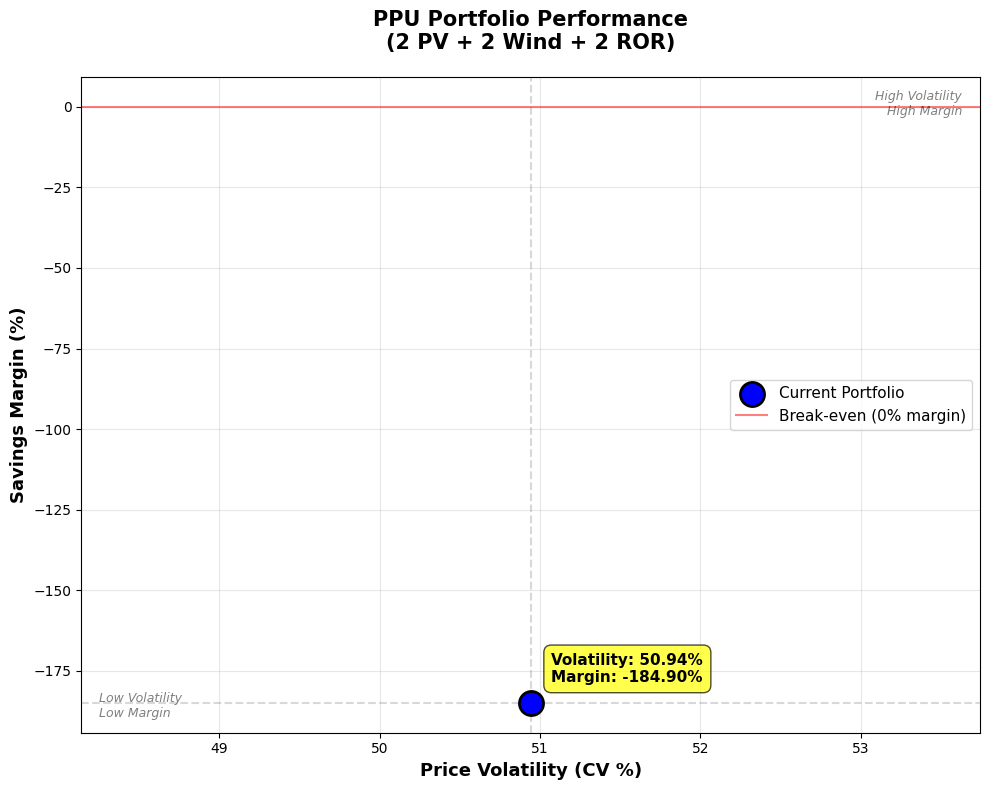


DETAILED COST BREAKDOWN

TOTAL PPU COST:        13,160,859,162.43 CHF
SPOT-ONLY COST:        4,619,397,281.07 CHF
SAVINGS:               -8,541,461,881.36 CHF (-184.90%)


In [ ]:
# Extract cost data from pipeline results
cost_summary = pipeline_results['cost_summary']
portfolio_result = pipeline_results['portfolio_result']

for tech_type, costs in cost_summary.items():
    print(f"\n{tech_type}:")
    print(f"  Production Cost:    {costs['production_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Purchases:     {costs['spot_buy_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Sales:        ({costs['spot_sell_revenue_CHF']:>15,.2f}) CHF")
    print(f"  Net Cost:           {costs['net_cost_CHF']:>15,.2f} CHF")


fig, ax = plt.subplots(figsize=(10, 8))

# Plot the portfolio point
ax.scatter(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct'], 
          s=300, c='blue', marker='o', edgecolors='black', linewidth=2, 
          label='Current Portfolio', zorder=5)

# Add labels
ax.annotate(f"Volatility: {portfolio_result['x_volatility_pct']:.2f}%\nMargin: {portfolio_result['y_margin_pct']:.2f}%",
           xy=(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct']),
           xytext=(15, 15), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
           fontsize=11, fontweight='bold')

# Add reference lines
ax.axhline(y=portfolio_result['y_margin_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=portfolio_result['x_volatility_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, label='Break-even (0% margin)')

# Styling
ax.set_xlabel('Price Volatility (CV %)', fontsize=13, fontweight='bold')
ax.set_ylabel('Savings Margin (%)', fontsize=13, fontweight='bold')
ax.set_title('PPU Portfolio Performance\n(2 PV + 2 Wind + 2 ROR)', 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add quadrant labels
ax.text(0.98, 0.98, 'High Volatility\nHigh Margin', 
       transform=ax.transAxes, ha='right', va='top',
       fontsize=9, style='italic', alpha=0.5)
ax.text(0.02, 0.02, 'Low Volatility\nLow Margin', 
       transform=ax.transAxes, ha='left', va='bottom',
       fontsize=9, style='italic', alpha=0.5)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "=" * 80)
print("DETAILED COST BREAKDOWN")
print("=" * 80)


print("\n" + "=" * 80)
print(f"TOTAL PPU COST:        {portfolio_result['total_cost_CHF']:>15,.2f} CHF")
print(f"SPOT-ONLY COST:        {portfolio_result['spot_only_cost_CHF']:>15,.2f} CHF")
print(f"SAVINGS:               {portfolio_result['savings_CHF']:>15,.2f} CHF ({portfolio_result['y_margin_pct']:+.2f}%)")
print("=" * 80)

## PPU and Storage Evolution Visualization

These functions allow you to analyze the behavior of your PPU portfolio over time:

### PPU Evolution (`visualize_ppu_evolution`)
Visualize production, spot market transactions, and net energy flow for:
- **All PPUs**: Stacked area chart showing relative contribution of each technology
- **Individual PPU**: Detailed 3-panel view showing production, spot transactions, and net flow

### Storage Evolution (`visualize_storage_evolution`)
Visualize storage levels over time showing:
- Storage capacity vs. current level
- State of Charge (SoC) percentage
- Target SoC reference line
- Statistics: initial, final, min, max, and average SoC

### Time Range Filtering
Both functions support time range filtering:
- Full year: `time_range=None` (default)
- First week: `time_range=(0, 672)` (7 days × 96 timesteps/day)
- First month: `time_range=(0, 2880)` (30 days × 96 timesteps/day)
- Summer months: `time_range=(12096, 21024)` (June-August)


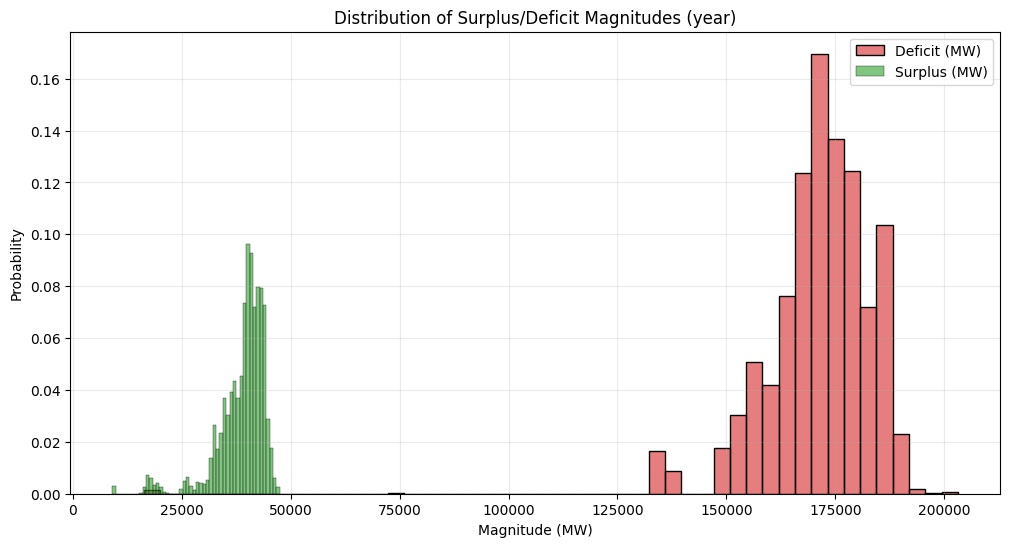

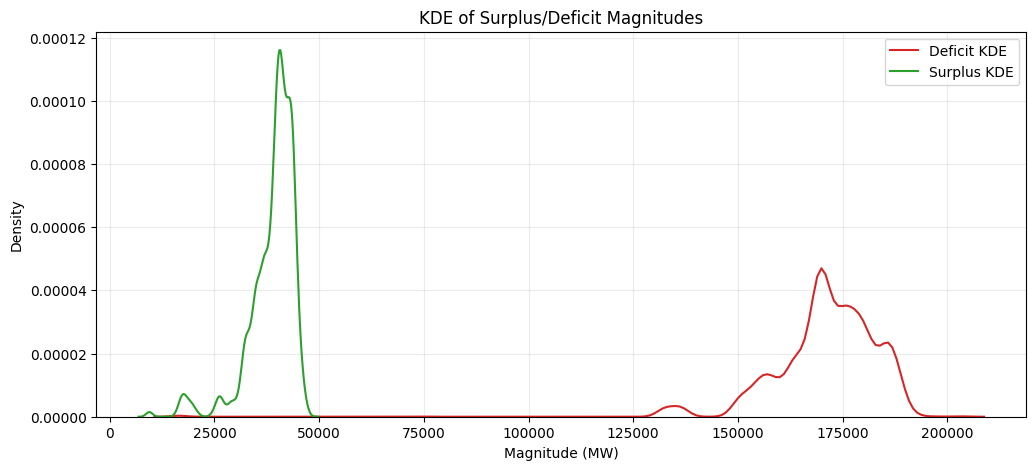

=== Surplus/Deficit Summary ===
Timesteps with deficit: 14,082
Timesteps with surplus: 21,051
From pipeline stats (epsilon=1e-06):
  deficit count (overflow_count): 15019
  surplus count:                 20114
  balanced count:                0
  shares: deficit 42.7%, surplus 57.3%, balanced 0.0%

Magnitude (MW) percentiles:
  P50: deficit 171695.45 MW | surplus  40229.70 MW
  P75: deficit 179274.67 MW | surplus  42491.21 MW
  P90: deficit 185353.89 MW | surplus  43884.53 MW
  P95: deficit 187215.50 MW | surplus  44497.53 MW
  P99: deficit 189137.62 MW | surplus  45829.52 MW


In [ ]:
# Try to extract a net grid balance series from available results
# Convention (from pipeline):
#   balance_MW > +epsilon  => deficit (we had to buy / unmet by supply)
#   balance_MW < -epsilon  => surplus (we could sell / had extra)

def find_balance_series(epsilon=1e-6):
    # 1) Prefer explicit keys in pipeline_results
    if isinstance(pipeline_results, dict):
        for k in ["overflow_series", "overflow_MW", "grid_balance", "balance_MW"]:
            s = pipeline_results.get(k, None)
            if s is not None:
                try:
                    s = pd.Series(s)
                    s.name = "balance_MW"
                    return s
                except Exception:
                    pass
        # 2) A dispatch DataFrame with a balance/overflow column
        for k in ["dispatch", "timeseries", "ts", "df"]:
            obj = pipeline_results.get(k, None)
            if isinstance(obj, pd.DataFrame):
                for col in obj.columns:
                    if col.lower() in ("overflow_mw", "balance_mw", "grid_balance"):
                        s = obj[col].copy()
                        s.name = "balance_MW"
                        return s
        # 3) Technology_volume may have a balance if present
        tv = pipeline_results.get("technology_volume")
        if isinstance(tv, dict):
            # If a dedicated key exists
            for k in ["grid_balance", "balance_MW", "overflow_MW"]:
                if k in tv and hasattr(tv[k], "__len__"):
                    try:
                        s = pd.Series(tv[k])
                        s.name = "balance_MW"
                        return s
                    except Exception:
                        pass
    # 4) Nothing found
    return None

def _to_1d(arr):
    """Convert arr to 1D float array; if 2D, aggregate across columns."""
    a = np.asarray(arr)
    if a.ndim == 1:
        return a.astype(float)
    if a.ndim >= 2:
        # Sum across last axis to aggregate any sub-components
        a = np.sum(a, axis=-1)
        return a.astype(float)
    return np.array([], dtype=float)

def compute_balance_from_spot(epsilon=1e-6):
    """Fallback: reconstruct balance from aggregated spot transactions across PPUs.
    Positive => deficit (net bought), Negative => surplus (net sold).
    Uses data_shapes['spot'] for canonical length when available.
    """
    if not isinstance(pipeline_results, dict):
        return None
    tv = pipeline_results.get("technology_volume")
    shapes = pipeline_results.get("data_shapes", {})
    spot_len = int(shapes.get("spot", 0))
    if not isinstance(tv, dict) or spot_len <= 0:
        return None

    bought_total = np.zeros(spot_len, dtype=float)
    sold_total = np.zeros(spot_len, dtype=float)

    def _fit_len(arr, L):
        arr = _to_1d(arr)
        if arr.size == L:
            return arr
        if arr.size == 0:
            return np.zeros(L, dtype=float)
        if arr.size > L:
            return arr[:L]
        # pad
        out = np.zeros(L, dtype=float)
        out[:arr.size] = arr
        return out

    for name, rec in tv.items():
        if not isinstance(rec, dict):
            continue
        if "spot_bought" in rec:
            bought_total += _fit_len(rec["spot_bought"], spot_len)
        if "spot_sold" in rec:
            sold_total += _fit_len(rec["spot_sold"], spot_len)

    balance = bought_total - sold_total
    return pd.Series(balance, name="balance_MW")

balance = find_balance_series(epsilon)
if balance is None:
    balance = compute_balance_from_spot(epsilon)

if balance is None:
    print("No balance/overflow time series found or reconstructable from spot transactions.\n"
          "Please ensure the pipeline exports a 'balance_MW' or 'overflow_MW' series, or per-PPU spot arrays.")
else:
    # Clean to numpy for speed
    x = balance.values.astype(float)
    # Split magnitudes for readability
    deficit_mag = x[x > epsilon]                # MW above +epsilon
    surplus_mag = -x[x < -epsilon]              # MW below -epsilon, take magnitude

    # Summary from pipeline stats if available
    stats = None
    if isinstance(pipeline_results, dict):
        stats = pipeline_results.get("pipeline_stats")
        if stats is None:
            # Some runs store stats under Technology_volume['__pipeline_stats__']
            tv = pipeline_results.get("technology_volume")
            if isinstance(tv, dict):
                stats = tv.get("__pipeline_stats__")
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    bins = 50
    sns.histplot(deficit_mag, bins=bins, color="#d62728", alpha=0.6, stat="probability", label="Deficit (MW)")
    sns.histplot(surplus_mag, bins=bins, color="#2ca02c", alpha=0.6, stat="probability", label="Surplus (MW)")
    plt.xlabel("Magnitude (MW)")
    plt.ylabel("Probability")
    plt.title("Distribution of Surplus/Deficit Magnitudes (year)")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

    # Optional: KDE overlay for smooth shape
    plt.figure(figsize=(12, 5))
    if len(deficit_mag) > 1:
        sns.kdeplot(deficit_mag, color="#d62728", label="Deficit KDE")
    if len(surplus_mag) > 1:
        sns.kdeplot(surplus_mag, color="#2ca02c", label="Surplus KDE")
    plt.xlabel("Magnitude (MW)")
    plt.ylabel("Density")
    plt.title("KDE of Surplus/Deficit Magnitudes")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

    # Print quick stats
    print("=== Surplus/Deficit Summary ===")
    print(f"Timesteps with deficit: {deficit_mag.size:,}")
    print(f"Timesteps with surplus: {surplus_mag.size:,}")
    if stats:
        oc = stats.get("overflow_count")
        sc = stats.get("surplus_count")
        bc = stats.get("balanced_count")
        total = (oc or 0) + (sc or 0) + (bc or 0)
        print(f"From pipeline stats (epsilon={epsilon}):")
        print(f"  deficit count (overflow_count): {oc}")
        print(f"  surplus count:                 {sc}")
        print(f"  balanced count:                {bc}")
        if total:
            print(f"  shares: deficit {oc/total:.1%}, surplus {sc/total:.1%}, balanced {bc/total:.1%}")

    print("\nMagnitude (MW) percentiles:")
    for p in [50, 75, 90, 95, 99]:
        dm = np.percentile(deficit_mag, p) if deficit_mag.size else 0.0
        sm = np.percentile(surplus_mag, p) if surplus_mag.size else 0.0
        print(f"  P{p:>2}: deficit {dm:9.2f} MW | surplus {sm:9.2f} MW")

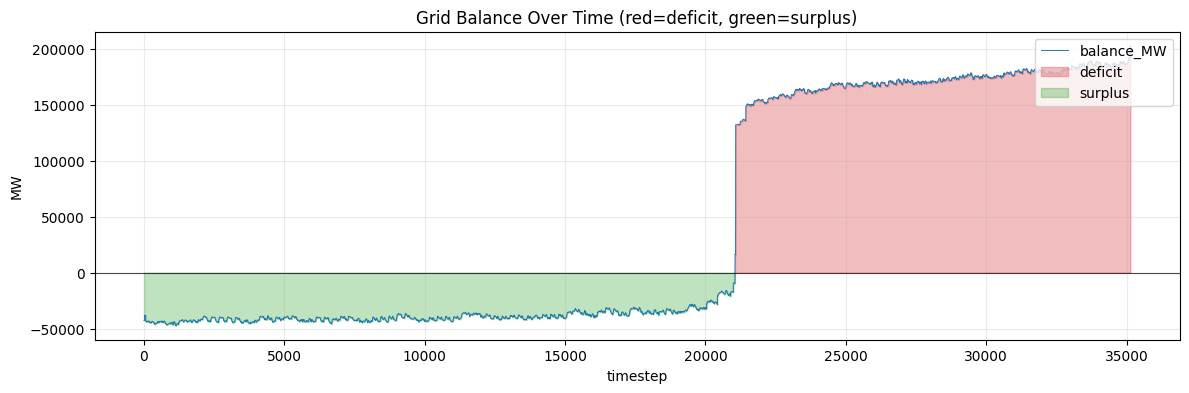

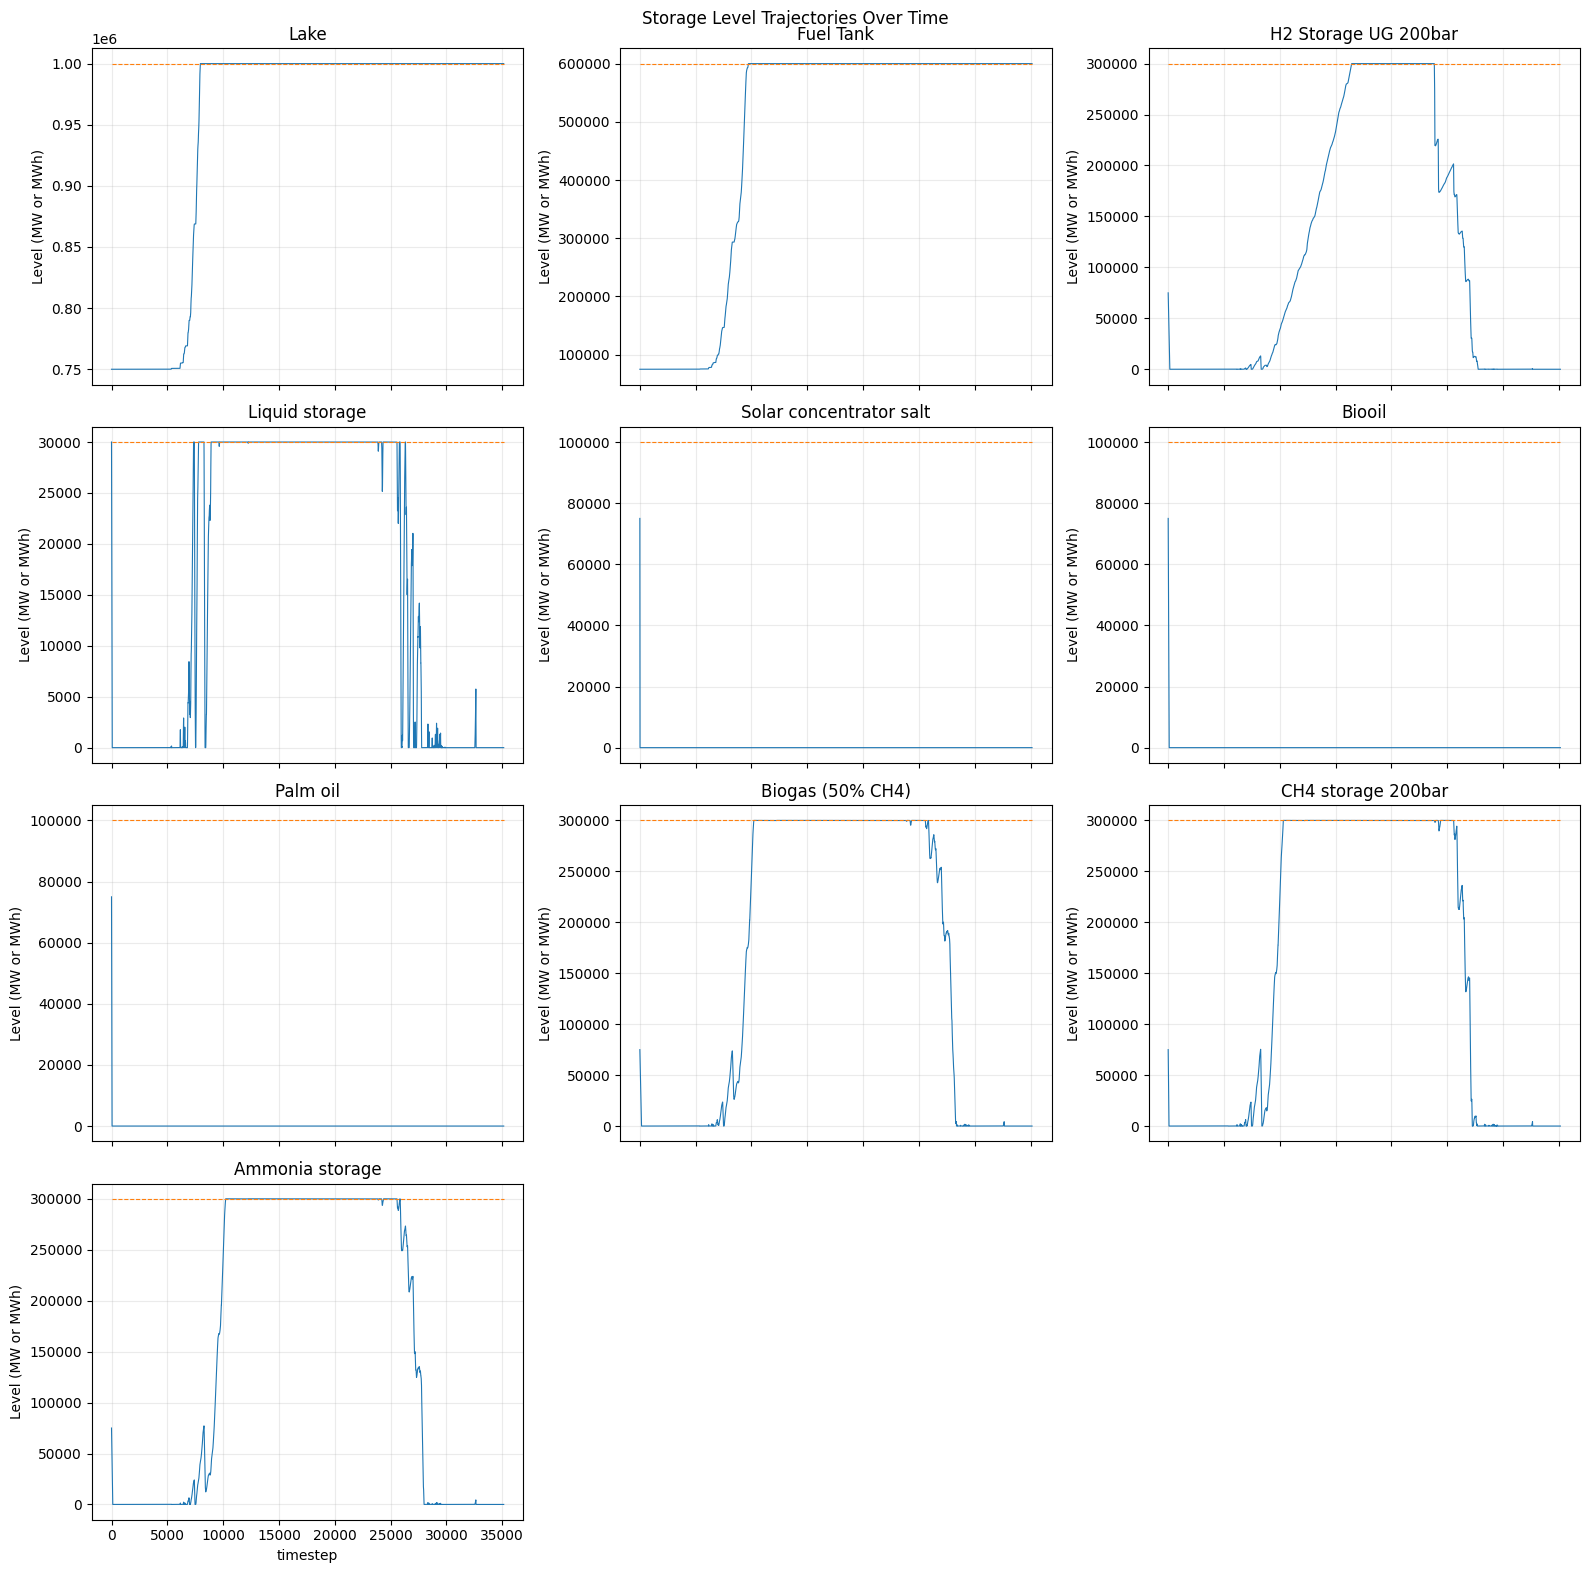

In [ ]:
# Time-series: deficit/surplus over time and storage level trajectories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse epsilon if defined, else fallback
_eps = globals().get('epsilon', 1e-6)

# Get balance time series from prior cell if available; else try to reconstruct
b = None
try:
    b = balance  # from previous cell
except NameError:
    pass

if b is None:
    # Try helper functions defined in the previous cell
    try:
        b = find_balance_series(_eps)
        if b is None:
            b = compute_balance_from_spot(_eps)
    except Exception:
        b = None

if b is None:
    print("No balance/overflow time series found or reconstructable. Skipping time-series plot.")
else:
    b = pd.Series(b).astype(float)
    N = len(b)
    t_idx = np.arange(N)

    # Plot balance over time with shaded regions
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t_idx, b.values, color="#1f77b4", linewidth=0.7, label="balance_MW")

    # Shade deficit (b > +eps) in red and surplus (b < -eps) in green
    ax.fill_between(t_idx, 0, b.values, where=(b.values > _eps), color="#d62728", alpha=0.3, label="deficit")
    ax.fill_between(t_idx, 0, b.values, where=(b.values < -_eps), color="#2ca02c", alpha=0.3, label="surplus")

    ax.axhline(0, color="black", linewidth=0.8, alpha=0.7)
    ax.set_title("Grid Balance Over Time (red=deficit, green=surplus)")
    ax.set_xlabel("timestep")
    ax.set_ylabel("MW")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.25)
    plt.show()

# Storage level trajectories
# We reconstruct each storage's level over time from its delta history and final current_value.

def reconstruct_storage_series(rec, length):
    """Rebuild storage level time series from (t, delta) history and final current_value.
    Returns (level, capacity, name)."""
    name = rec.get('storage') or rec.get('name') or 'Storage'
    cap = float(rec.get('value', 0.0))
    final_val = float(rec.get('current_value', 0.0))
    history = rec.get('history') or []

    deltas = np.zeros(length, dtype=float)
    for item in history:
        try:
            t, delta = item
            ti = int(t)
            if 0 <= ti < length:
                deltas[ti] += float(delta)
        except Exception:
            continue
    baseline = final_val - float(deltas.sum())  # initial level
    level = baseline + np.cumsum(deltas)
    # Optional clamp for visualization
    if cap > 0:
        level = np.clip(level, 0.0, cap)
    return level, cap, name

# Build plots if raw_energy_storage is present
have_storage = 'raw_energy_storage' in globals()
if not have_storage:
    print("raw_energy_storage not found in this kernel; skipping storage plots.")
else:
    try:
        storages = raw_energy_storage
    except Exception:
        storages = None

    if not isinstance(storages, (list, tuple)) or len(storages) == 0:
        print("No storage records available; skipping storage plots.")
    else:
        # Determine time length from balance if present; otherwise infer from longest history index
        if b is not None:
            L = len(b)
        else:
            max_t = 0
            for rec in storages:
                hist = rec.get('history') or []
                for item in hist:
                    try:
                        ti = int(item[0])
                        if ti > max_t:
                            max_t = ti
                    except Exception:
                        pass
            L = max_t + 1 if max_t > 0 else 0

        if L == 0:
            print("Could not infer time length for storage histories; skipping storage plots.")
        else:
            t_idx = np.arange(L)
            n = len(storages)
            ncols = 3
            nrows = int(np.ceil(n / ncols))
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharex=True)
            if nrows * ncols == 1:
                axes = np.array([axes])
            axes = axes.reshape(nrows, ncols)

            for i, rec in enumerate(storages):
                r = i // ncols
                c = i % ncols
                ax = axes[r, c]
                series, cap, name = reconstruct_storage_series(rec, L)
                ax.plot(t_idx, series, color="#1f77b4", linewidth=0.8)
                if cap > 0:
                    ax.hlines(cap, t_idx[0], t_idx[-1], colors="#ff7f0e", linestyles="--", linewidth=0.8, label="capacity")
                ax.set_title(f"{name}")
                ax.set_ylabel("Level (MW or MWh)")
                ax.grid(True, alpha=0.25)
                if r == nrows - 1:
                    ax.set_xlabel("timestep")

            # Hide any unused subplots
            for j in range(n, nrows * ncols):
                r = j // ncols
                c = j % ncols
                axes[r, c].axis('off')

            fig.suptitle("Storage Level Trajectories Over Time", y=0.98)
            plt.tight_layout()
            plt.show()

In [ ]:
# Assumed timestep length in hours (15 minutes)
dt_hours = 0.25

# Balance summary
if 'b' in locals() and b is not None:
    bb = pd.Series(b).astype(float)
    deficit = bb[bb > _eps]
    surplus = -bb[bb < -_eps]
    stats_rows = [
        ["timesteps_deficit", int(deficit.size)],
        ["timesteps_surplus", int(surplus.size)],
        ["total_deficit_MWh", float(deficit.sum() * dt_hours)],
        ["total_surplus_MWh", float(surplus.sum() * dt_hours)],
        ["mean_deficit_MW", float(deficit.mean() if deficit.size else 0.0)],
        ["mean_surplus_MW", float(surplus.mean() if surplus.size else 0.0)],
        ["p95_deficit_MW", float(np.percentile(deficit, 95) if deficit.size else 0.0)],
        ["p95_surplus_MW", float(np.percentile(surplus, 95) if surplus.size else 0.0)],
    ]
    balance_summary = pd.DataFrame(stats_rows, columns=["metric", "value"])
    print("Balance summary (assuming 15-min steps):")
    display(balance_summary)
else:
    print("No balance series available for summary.")

# Storage utilization summary
if 'raw_energy_storage' in globals() and isinstance(raw_energy_storage, (list, tuple)) and len(raw_energy_storage) > 0:
    def reconstruct_storage_series(rec, length):
        cap = float(rec.get('value', 0.0))
        final_val = float(rec.get('current_value', 0.0))
        history = rec.get('history') or []
        deltas = np.zeros(length, dtype=float)
        for item in history:
            try:
                t, delta = item
                ti = int(t)
                if 0 <= ti < length:
                    deltas[ti] += float(delta)
            except Exception:
                pass
        baseline = final_val - float(deltas.sum())
        level = baseline + np.cumsum(deltas)
        if cap > 0:
            level = np.clip(level, 0.0, cap)
        return level, cap

    # Determine L (prefer from balance)
    if 'b' in locals() and b is not None:
        L = len(b)
    else:
        max_t = 0
        for rec in raw_energy_storage:
            for item in (rec.get('history') or []):
                try:
                    ti = int(item[0])
                    if ti > max_t:
                        max_t = ti
                except Exception:
                    pass
        L = max_t + 1 if max_t > 0 else 0

    rows = []
    for rec in raw_energy_storage:
        name = rec.get('storage') or rec.get('name') or 'Storage'
        level, cap = reconstruct_storage_series(rec, L) if L > 0 else (np.array([]), float(rec.get('value', 0.0)))
        if level.size:
            pct_full = float(np.mean(level >= 0.99 * cap) * 100.0) if cap > 0 else 0.0
            pct_empty = float(np.mean(level <= 0.01 * cap) * 100.0) if cap > 0 else 0.0
            rows.append({
                'storage': name,
                'capacity': cap,
                'initial': float(level[0]),
                'final': float(level[-1]),
                'min': float(level.min()),
                'mean': float(level.mean()),
                'max': float(level.max()),
                '%time_near_full(>=99%)': pct_full,
                '%time_near_empty(<=1%)': pct_empty,
            })
        else:
            rows.append({
                'storage': name,
                'capacity': cap,
                'initial': np.nan,
                'final': np.nan,
                'min': np.nan,
                'mean': np.nan,
                'max': np.nan,
                '%time_near_full(>=99%)': np.nan,
                '%time_near_empty(<=1%)': np.nan,
            })

    storage_summary = pd.DataFrame(rows)
    display(storage_summary.sort_values('storage').reset_index(drop=True))
else:
    print("No storage records available for summary.")

Balance summary (assuming 15-min steps):


,metric,value
0,timesteps_deficit,1.408200e+04
1,timesteps_surplus,2.105100e+04
2,total_deficit_MWh,6.026157e+08
3,total_surplus_MWh,2.044589e+08
4,mean_deficit_MW,1.711733e+05
5,mean_surplus_MW,3.885020e+04
6,p95_deficit_MW,1.872155e+05
7,p95_surplus_MW,4.449753e+04


,storage,capacity,initial,final,min,mean,max,%time_near_full(>=99%),%time_near_empty(<=1%)
0,Ammonia storage,300000.0,75000.0,0.000000e+00,0.000000e+00,152254.507549,300000.0,43.728119,40.264139
1,Biogas (50% CH4),300000.0,75000.0,1.600711e-10,0.000000e+00,155515.865831,300000.0,43.967210,39.031680
2,Biooil,100000.0,75000.0,0.000000e+00,0.000000e+00,84.194303,75000.0,0.000000,99.780833
3,CH4 storage 200bar,300000.0,75000.0,2.037268e-10,0.000000e+00,146521.491858,300000.0,43.073464,42.219566
4,Fuel Tank,600000.0,75000.0,6.000000e+05,7.500000e+04,472329.813403,600000.0,72.458942,0.000000
5,H2 Storage UG 200bar,300000.0,75000.0,1.746230e-10,0.000000e+00,109023.841458,300000.0,21.242137,43.124698
6,Lake,1000000.0,750000.0,1.000000e+06,7.500000e+05,947287.916106,1000000.0,77.479862,0.000000
7,Liquid storage,30000.0,30000.0,7.275958e-12,0.000000e+00,16089.637214,30000.0,48.916973,39.859961
8,Palm oil,100000.0,75000.0,2.910383e-11,2.910383e-11,42.629818,75000.0,0.000000,99.888993
9,Solar concentrator salt,100000.0,75000.0,0.000000e+00,0.000000e+00,7.011568,75000.0,0.000000,99.982922


# Optimal Power Production Unit Portfolio Design: A Multi-Period Stochastic Optimization Framework

## Abstract

We present a novel two-stage optimization framework for designing resilient renewable energy portfolios under uncertainty. The methodology integrates mixed-integer programming with high-resolution temporal dispatch simulation (15-minute intervals) to minimize total system cost while managing downside risk through Conditional Value-at-Risk (CVaR₉₅). Our approach explicitly models storage dynamics, location-dependent renewable resources, and spot market interactions over rolling 30-day horizons constructed from randomly sampled daily periods.

---

## 1. Introduction

The transition to renewable-dominated power systems requires sophisticated portfolio optimization that accounts for:
- **Intermittency and uncertainty** in renewable generation
- **Storage capacity and cycling constraints**
- **Spatial constraints** for wind and solar installations
- **Downside risk exposure** to extreme cost scenarios

Traditional mean-variance optimization fails to capture the temporal coupling of storage systems and the fat-tailed distribution of net operating costs. We address these limitations through a scenario-based stochastic programming approach with coherent risk measures.

---

## 2. Mathematical Framework

### 2.1 Decision Variables

Let $\mathcal{T}$ denote the set of available PPU technologies. Our primary decision variables are:

$$
x_t \in \mathbb{N}_0 \quad \forall t \in \mathcal{T}
$$

representing the integer count of PPUs of type $t$ to install.

**Technology Categories:**
- **Location-dependent:** Solar PV, onshore wind, offshore wind (subject to unique site constraints)
- **Location-independent:** Hydro storage, pumped hydro, hydrogen systems, thermal units

### 2.2 Objective Function

We employ a risk-adjusted cost minimization objective combining expected cost with downside risk protection:

$$
\min_{x \in \mathbb{N}^{|\mathcal{T}|}_0} \quad \mathbb{E}_\omega[\text{NetCost}(x, \omega)] + \lambda \cdot \text{CVaR}_{95}[\text{NetCost}(x, \omega)]
$$

where:
- $\omega \in \Omega$ indexes scenarios (30-day periods constructed from randomly sampled days)
- $\lambda \geq 0$ is the risk-aversion parameter
- $\text{NetCost}(x, \omega)$ is the total system cost under portfolio $x$ and scenario $\omega$

**Unified Cost Structure:**

Each PPU has a levelized cost expressed in CHF/kWh that includes both CAPEX and OPEX. The total net cost is:

$$
\text{NetCost}(x, \omega) = \sum_{\tau=1}^{T} \sum_{t \in \mathcal{T}} P_{t,\tau}^{\text{prod}}(x) \cdot C_t^{\text{total}} \cdot \Delta t + \text{SpotCost}_\tau(\omega)
$$

where:
- $C_t^{\text{total}}$ is the all-in cost per kWh for technology $t$ (from cost tables)
- $T = 2{,}880$ timesteps (30 days × 96 steps/day)
- $\Delta t = 0.25$ hr (15-minute intervals)

**Scaling Cost Structure:**  
To prevent unbounded solutions and reflect diminishing returns, we apply cost escalation per additional unit:

$$
C_t^{\text{scaled}}(k) = C_t^{\text{total}} \cdot \left(1 + 0.1 \cdot (k-1)\right)
$$

where $k$ is the unit number for technology $t$. This regularization applies to **all PPU types** and ensures diversification is economically incentivized.

### 2.3 Conditional Value-at-Risk (CVaR₉₅)

**Definition:**  
For confidence level $\alpha = 0.95$, CVaR measures the expected cost in the worst 5% of scenarios:

$$
\text{CVaR}_\alpha[\text{NetCost}] = \min_{\zeta} \left\{ \zeta + \frac{1}{1-\alpha} \mathbb{E}_\omega\left[ [\text{NetCost}(\omega) - \zeta]^+ \right] \right\}
$$

where $[x]^+ = \max(0, x)$ and $\zeta$ is the Value-at-Risk (VaR) threshold.

**Computational Procedure:**

1. **Sort scenario costs:** Order $\{\text{NetCost}(x, \omega_1), \ldots, \text{NetCost}(x, \omega_N)\}$ in ascending order

2. **Identify VaR threshold:** Find $\zeta_\alpha$ such that:
   $$
   \zeta_\alpha = \inf\{z : P(\text{NetCost} \leq z) \geq \alpha\}
   $$
   
   For $N = 20$ scenarios and $\alpha = 0.95$, this is the 19th value (95th percentile).

3. **Compute CVaR as conditional mean:**
   $$
   \text{CVaR}_{95} = \frac{1}{N(1-\alpha)} \sum_{\omega: \text{NetCost}(\omega) > \zeta_{95}} \text{NetCost}(\omega)
   $$
   
   Average the costs of the worst $\lceil N \times 0.05 \rceil$ scenarios.

**Properties:**
- **Coherent:** Satisfies sub-additivity, positive homogeneity, translation invariance, monotonicity
- **Convex:** Enables efficient optimization with linear programming
- **Tail-sensitive:** Captures extreme downside risk better than standard deviation
- **Interpretable:** "If things go bad (worst 5%), what is the expected cost?"

**Example (N=20 scenarios):**
- Sort costs: $[c_1, c_2, \ldots, c_{20}]$
- VaR₉₅ = $c_{19}$
- CVaR₉₅ = $(c_{19} + c_{20})/2$

---

## 3. Constraints

### 3.1 Energy Balance (All Timesteps)

At each 15-minute interval $\tau$:

$$
\sum_{t \in \mathcal{T}} P_{t,\tau}^{\text{prod}}(x) + P_\tau^{\text{import}} - P_\tau^{\text{export}} + \Delta S_\tau = D_\tau
$$

where:
- $P_{t,\tau}^{\text{prod}}$: Production from technology $t$ (MW)
- $P_\tau^{\text{import/export}}$: Spot market transactions (MW)
- $\Delta S_\tau = S_{\tau-1} - S_\tau$: Net storage discharge (MW)
- $D_\tau$: Electricity demand (MW)

### 3.2 Storage Dynamics

For each storage system $s$ with capacity scaling:

$$
0 \leq \text{SOC}_{s,\tau} \leq \sum_{t \in \mathcal{C}_s} x_t \cdot \text{Cap}_{s,t}
$$

where $\mathcal{C}_s$ is the set of PPU types that contribute to storage $s$.

**Important:** For Lake storage:
- **Only PHS contributes capacity:** $\mathcal{C}_{\text{Lake}} = \{\text{PHS}\}$
- **HYD_S extracts but does not contribute:** HYD_S discharges from Lake but does not add storage capacity
- **PHS can both charge and discharge:** PHS pumps water into Lake (charging) and can also generate by releasing water

**State-of-Charge Evolution:**

$$
\text{SOC}_{s,\tau} = \text{SOC}_{s,\tau-1} + \eta_s^{\text{in}} \cdot E_{s,\tau}^{\text{charge}} - \frac{1}{\eta_s^{\text{out}}} \cdot E_{s,\tau}^{\text{discharge}}
$$

with round-trip efficiencies $\eta_s^{\text{in}}$, $\eta_s^{\text{out}} \in (0,1]$.

### 3.3 Renewable Resource Availability

For location-dependent renewables (solar PV, wind):

$$
P_{t,\tau}^{\text{prod}} \leq x_t \cdot \text{Incidence}_{t,\tau}^{(\ell_t)} \quad \forall t \in \mathcal{T}_{\text{renewable}}
$$

where $\ell_t$ is the assigned location rank for technology $t$.

**Uniqueness Constraint:**  
$$
\ell_t \neq \ell_{t'} \quad \forall t, t' \in \mathcal{T}_{\text{renewable}}, \; t \neq t'
$$

No two renewable PPUs may occupy the same geographical site. This constraint ensures realistic spatial distribution and prevents double-counting of optimal locations.

### 3.4 Technology Diversity (Portfolio Concentration Limit)

To ensure resilience, we limit market concentration using the Herfindahl-Hirschman Index (HHI):

$$
\text{HHI} = \sum_{t \in \mathcal{T}} \left( \frac{E_t}{\sum_{t' \in \mathcal{T}} E_{t'}} \right)^2 \leq \theta
$$

where $E_t = \sum_\tau P_{t,\tau}^{\text{prod}} \cdot \Delta t$ is the total energy contributed by technology $t$ over the horizon.

**Typical bounds:** $\theta \in [0.25, 0.35]$ prevents single-technology dominance while allowing specialization. Lower HHI indicates higher diversification.

---

## 4. Scenario Generation and Evaluation

### 4.1 Random Daily Sampling Strategy

We construct each 30-day evaluation scenario by randomly sampling **individual days** from the full year:

**Algorithm:**
1. For each scenario $\omega$:
   - Randomly select 30 days from the 365-day annual dataset (with or without replacement)
   - For each selected day $d_i$, extract all 96 timesteps (15-min resolution)
   - Concatenate into a 2,880-timestep sequence
   
2. For each timestep $\tau$ in scenario $\omega$, extract:
   - Demand profile $D_\tau(\omega)$
   - Renewable incidence $\text{Incidence}_{t,\tau}(\omega)$ for all solar/wind locations
   - Spot market prices $\pi_\tau(\omega)$

3. Run dispatch simulation for portfolio $x$ under scenario $\omega$

**Advantages:**
- **Maximum diversity:** Each scenario explores different seasonal combinations
- **Captures extremes:** Can combine worst-case days from different periods
- **Stress testing:** Evaluates portfolio robustness under arbitrary weather/price sequences
- **Simple implementation:** No need for complex time-series modeling

**Note:** This approach sacrifices temporal correlation (e.g., multi-day cloud cover patterns) in favor of broader scenario coverage. The optimizer evaluates many random combinations and selects portfolios that perform well across all of them.

### 4.2 Dispatch Simulation Engine

For a given portfolio $x$ and scenario $\omega$, the simulation proceeds sequentially:

**For each timestep** $\tau = 1, \ldots, 2{,}880$**:**

1. **Renewable Collection:**  
   Harvest available renewable energy based on incidence and installed capacity

2. **Net System Balance:**  
   Compute deficit/surplus: $\Phi_\tau = D_\tau - E_\tau^{\text{renew}}$ (MW)

3. **Dispatch Decision:**
   - **Shortfall** ($\Phi_\tau > 0$): Discharge storages and/or purchase from spot market
   - **Surplus** ($\Phi_\tau < 0$): Charge storages and/or sell to spot market
   - **Balanced** ($|\Phi_\tau| < \epsilon$): No action required

4. **Storage Allocation:**  
   Use disposition-utility-cost indices to allocate flows inversely proportional to dispatch cost

5. **Spot Market Transactions:**  
   Record residual import/export after exhausting storage capacity

**Output:** Time series of $(P_\tau^{\text{import}}, P_\tau^{\text{export}}, \text{SOC}_{s,\tau})$ for scenario $\omega$.

### 4.3 Performance Metrics

For portfolio $x$ across scenarios $\{\omega_1, \ldots, \omega_N\}$:

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **Mean Net Cost** | $\bar{C}(x) = \frac{1}{N}\sum_{\omega} \text{NetCost}(x, \omega)$ | Expected total system cost |
| **CVaR₉₅** | $\text{CVaR}_{95}[\text{NetCost}(x, \cdot)]$ | Average cost in worst 5% scenarios |
| **Spot Dependence** | $\frac{\sum_\tau P_\tau^{\text{import}}}{\sum_\tau D_\tau}$ | Fraction of demand met via spot |
| **Storage Utilization** | $\frac{1}{T}\sum_\tau \frac{\text{SOC}_{s,\tau}}{\text{Capacity}_s}$ | Average state-of-charge |
| **HHI** | $\sum_t \left(\frac{E_t}{\sum_{t'} E_{t'}}\right)^2$ | Technology concentration |

---

## 5. Solution Methodology

### 5.1 Iterative Portfolio Evaluation

**Optimization Procedure:**

For each candidate portfolio $x$:

1. **Generate random scenario** $\omega$:
   - Randomly select 30 days from the annual dataset
   - Build 2,880-timestep demand, incidence, and price sequences

2. **Run dispatch simulation:**
   - Execute 15-minute resolution dispatch over the 30-day period
   - Compute $\text{NetCost}(x, \omega)$ including all energy transactions and storage operations

3. **Record performance:**
   - Store $(x, \text{NetCost}(x, \omega), \omega)$ in results database
   - Track technology mix, HHI, storage utilization, spot dependence

4. **Iterate:**
   - Repeat steps 1-3 for many portfolio configurations $x$
   - Accumulate scenario evaluations over time

**Solver Options:**
- **Gurobi:** Mixed-integer optimization with branch-and-bound
- **Genetic Algorithm:** Evolutionary search over discrete portfolio space
- **Both acceptable** for initial exploration

### 5.2 Efficient Frontier Construction (Post-Processing)

After collecting many $(x, \text{NetCost}, \omega)$ tuples:

1. **Group by portfolio:** For each unique $x$, collect all scenario costs
   
2. **Compute metrics:**
   - $\bar{C}(x) = \text{mean}(\{\text{NetCost}(x, \omega_i)\})$
   - $\text{CVaR}_{95}(x) = \text{mean of worst 5%}(\{\text{NetCost}(x, \omega_i)\})$

3. **Plot frontier:**
   - Scatter plot with $\bar{C}(x)$ on x-axis, $\text{CVaR}_{95}(x)$ on y-axis
   - Identify Pareto-optimal portfolios (non-dominated solutions)
   - Annotate points with technology mix and HHI

4. **Select portfolio:**
   - Choose point on frontier based on risk tolerance
   - Extract optimal $x^*$ and visualize composition

**Key Insight:** We do NOT sweep $\lambda$ explicitly during optimization. Instead, we evaluate many portfolios under many scenarios, then post-process to construct the empirical efficient frontier mapping mean cost to tail risk.

---

## 6. Computational Implementation

### 6.1 Decision Variable Bounds

**Initial exploration (Phase 1):**

$$
x_t \in \{0, 1, 2, \ldots\} \quad \forall t \in \mathcal{T} \quad \text{(no upper bound)}
$$

**No constraints on PPU counts** to allow the optimizer to discover natural limits imposed by:
- Cost escalation via $(1 + 0.1k)$ penalty
- HHI diversity constraints
- Diminishing marginal returns

**Scenario set size:**

$$
N = 20 \text{ scenarios (randomly sampled 30-day windows from daily selections)}
$$

This provides a reasonable balance between computational cost and tail-risk estimation accuracy for initial runs.

### 6.2 Implementation Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| **Timesteps per scenario** | 2,880 | 30 days × 96 steps/day |
| **Δt** | 0.25 hr | 15-minute resolution |
| **Scenarios** | 20 | Random 30-day windows |
| **CVaR confidence** | 95% | Worst 5% tail risk |
| **Cost escalation** | 1 + 0.1(k-1) | Per-unit scaling penalty |

---

## 7. Expected Deliverables

### 7.1 Visualizations

1. ~~Efficient Frontier Plot~~ *(Deferred)*

2. **Optimal Portfolio Composition:**  
   Bar chart showing $x_t^*$ for selected portfolios (e.g., different points on empirical frontier)

3. **Deficit/Surplus Timeline:**  
   Time series of net system balance $\Phi_\tau$ over representative 30-day scenarios, shaded by surplus (green) and deficit (red) regions

4. **Storage State-of-Charge Trajectories:**  
   Multi-panel plot showing $\text{SOC}_{s,\tau}$ for each storage type, with capacity limits and cycling behavior

5. **Technology Market Share (HHI Analysis):**  
   Stacked area chart of energy contribution by technology type over time, with HHI score displayed

### 7.2 Summary Statistics Table

| Portfolio Metric | Value |
|------------------|-------|
| Total Installed Capacity (GW) | $\sum_t x_t$ |
| Expected Annual Cost (CHF) | $12 \times \bar{C}(x^*)$ |
| CVaR₉₅ (CHF) | $\text{CVaR}_{95}[\text{NetCost}(x^*)]$ |
| Spot Import Fraction (%) | $\frac{\sum_\tau P_\tau^{\text{import}}}{\sum_\tau D_\tau} \times 100$ |
| Average Storage Utilization (%) | $\frac{1}{|\mathcal{S}|} \sum_s \bar{\text{SOC}}_s$ |
| HHI Score | $\sum_t (E_t / E_{\text{total}})^2$ |
| Renewable Penetration (%) | $\frac{E_{\text{renew}}}{E_{\text{total}}} \times 100$ |

---

## 8. Implementation Roadmap

**Phase 1: Setup**
1. Define technology set $\mathcal{T}$ (no upper bounds on $x_t$)
2. Implement per-unit cost escalation: $C_t^{\text{scaled}}(k) = C_t^{\text{total}} \cdot (1 + 0.1(k-1))$
3. Build random daily scenario generator for 30-day windows

**Phase 2: Simulation**
4. For given $x$, run dispatch simulation across 20 scenarios
5. Compute $\text{NetCost}(x, \omega)$ for each scenario
6. Implement CVaR₉₅ calculation (mean of worst 5% = top 1 cost for N=20)

**Phase 3: Optimization**
7. Iterate over many portfolio configurations $x$
8. Accumulate $(x, \bar{C}, \text{CVaR}_{95})$ tuples
9. Use Gurobi or genetic algorithm to guide search

**Phase 4: Visualization**
10. Generate portfolio composition bar charts
11. Plot deficit/surplus timelines and storage trajectories
12. Compute and display HHI and summary statistics

---

## 9. Novel Contributions

Our framework advances existing portfolio optimization methods through:

1. **Random daily sampling:** Constructs 30-day scenarios from randomly selected individual days, maximizing scenario diversity and stress-testing capability

2. **Unified cost structure:** Treats CAPEX and OPEX as a single CHF/kWh metric with per-unit escalation, simplifying optimization while preserving diminishing returns

3. **Coherent risk measures:** CVaR₉₅ provides superior tail-risk control with clear interpretation and computational tractability

4. **Location-aware constraints:** Spatial uniqueness requirements for renewable sites prevent unrealistic double-counting of optimal locations

5. **Iterative portfolio evaluation:** Explores portfolio space through repeated scenario sampling, building empirical efficient frontier rather than solving monolithic MIP

6. **No artificial bounds:** Allows natural portfolio limits to emerge from cost penalties and diversity constraints rather than arbitrary caps

This methodology is suitable for strategic planning of renewable portfolios under uncertainty, with applications in utility-scale energy procurement, microgrid design, and carbon-neutral transition pathway optimization.

---

**Next Steps:** Proceed with Phase 1 implementation, starting with random daily scenario generator and basic dispatch infrastructure for 20-scenario evaluation.

## 10. Six-Step Implementation Timeline

### Step 1: Random Daily Scenario Generator (Week 1)

**Objective:** Build infrastructure to generate 30-day evaluation scenarios by randomly sampling individual days from the annual dataset.

---

#### Function 1.1: `load_annual_data`

**Purpose:** Load all 2024 annual datasets at 15-minute resolution and index by timestamp.

**Inputs:**
- `data_dir` (str): Path to data directory

**Outputs:**
- `data_dict` (dict): Dictionary containing:
  - `'demand_15min'`: Series[2880 timesteps] - Demand in MW
  - `'spot_15min'`: Series[2880 timesteps] - Spot prices in CHF/MWh
  - `'solar_incidence'`: DataFrame[8760 × locations] - Solar capacity factors
  - `'wind_incidence'`: DataFrame[8760 × locations] - Wind capacity factors
  - `'ror_15min'`: Series[2880 timesteps] - Run-of-river production
  - `'timestamp_index'`: DatetimeIndex - Full year timestamps

**Mathematical Formula:**
- Resample hourly data to 15-min: linear interpolation
- Validate: $\sum_{\text{timesteps}} = 365 \times 96 = 35040$ for 15-min resolution

**Associated Tests (4 tests):**

1. **`test_annual_data_completeness`**
   - Verify all required keys present in data_dict
   - Assert no missing values in any series
   - Check total timesteps = 35040

2. **`test_timestamp_continuity`**
   - Verify timestamps are evenly spaced at 15-min intervals
   - Check first timestamp = 2024-01-01 00:00:00
   - Check last timestamp = 2024-12-31 23:45:00

3. **`test_renewable_location_coverage`**
   - Assert solar_incidence has ≥ 10 location columns
   - Assert wind_incidence has ≥ 10 location columns
   - Verify all capacity factors in [0, 1]

4. **`test_data_loading_determinism`**
   - Load data twice, verify identical values
   - Check data types (float64 for series, datetime64 for index)

---

#### Function 1.2: `generate_random_scenario`

**Purpose:** Randomly select 30 individual days from annual data and concatenate into 2880-timestep scenario.

**Inputs:**
- `n_days` (int): Number of days to sample (default=30)
- `data_dict` (dict): Output from `load_annual_data`
- `seed` (int, optional): Random seed for reproducibility

**Outputs:**
- `scenario_dict` (dict):
  - `'demand_15min'`: Series[2880] - Concatenated demand
  - `'spot_15min'`: Series[2880] - Concatenated spot prices
  - `'solar_15min'`: DataFrame[2880 × locations] - Solar capacity factors
  - `'wind_15min'`: DataFrame[2880 × locations] - Wind capacity factors
  - `'ror_15min'`: Series[2880] - RoR production
  - `'day_indices'`: List[int] - Indices of selected days (0-364)
  - `'sampled_dates'`: List[datetime] - Actual dates sampled

**Mathematical Formula:**
- Sample days: $D = \{d_1, d_2, ..., d_{30}\}$ where $d_i \in [0, 364]$, all unique
- For each day $d_i$: extract timesteps $[d_i \times 96 : (d_i+1) \times 96]$
- Concatenate: $\text{scenario}[96i : 96(i+1)] = \text{annual\_data}[d_i \times 96 : (d_i+1) \times 96]$

**Associated Tests (7 tests):**

1. **`test_scenario_length`**
   - Verify scenario has exactly 2880 timesteps
   - Assert all series have same length
   - Check = 30 days × 96 timesteps/day

2. **`test_scenario_determinism`**
   - Generate two scenarios with same seed
   - Assert identical demand_15min values
   - Assert identical day_indices

3. **`test_day_selection_range`**
   - Verify all day_indices in [0, 364]
   - Check exactly 30 unique days (no duplicates)
   - Assert len(set(day_indices)) == 30

4. **`test_day_data_integrity`** ⭐ **NEW**
   - For each sampled day, extract corresponding 96 timesteps from annual data
   - Compare against scenario data for that day
   - Assert exact match (no information loss during sampling)
   - Formula: `scenario[96i:96(i+1)] == annual_data[day_idx*96:(day_idx+1)*96]`

5. **`test_sampled_dates_validity`** ⭐ **NEW**
   - Verify all sampled_dates exist in annual timestamp_index
   - Check each date corresponds to correct day_index
   - Assert date alignment: `sampled_dates[i] == timestamp_index[day_indices[i]*96]`

6. **`test_scenario_diversity`**
   - Generate scenarios with different seeds (seed=1, seed=2)
   - Assert different day_indices
   - Verify demand profiles differ

7. **`test_renewable_incidence_preservation`**
   - Check solar_15min maintains location structure
   - Verify all capacity factors still in [0, 1]
   - Assert no NaN values introduced during concatenation

---

#### Function 1.3: `validate_scenario_completeness`

**Purpose:** Ensure scenario contains all required data and matches expected structure.

**Inputs:**
- `scenario_dict` (dict): Output from `generate_random_scenario`
- `expected_locations` (dict): {'solar': int, 'wind': int} - Expected location counts

**Outputs:**
- `is_valid` (bool): True if all checks pass
- `validation_report` (dict): Details of any issues found

**Mathematical Formula:**
- Check: $|\text{scenario}| = 2880$
- Check: $\forall t \in [0, 2879]: \text{demand}(t) > 0$
- Check: $\forall t,\ell: 0 \leq \text{CF}_\ell(t) \leq 1$

**Associated Tests (3 tests):**

1. **`test_validation_accepts_valid_scenario`**
   - Generate valid scenario
   - Assert validator returns `is_valid=True`
   - Check validation_report is empty or contains only info

2. **`test_validation_rejects_incomplete_scenario`**
   - Create scenario missing 'spot_15min' key
   - Assert validator returns `is_valid=False`
   - Check validation_report contains specific error

3. **`test_validation_detects_wrong_length`**
   - Create scenario with 2000 timesteps (invalid)
   - Assert validator catches length mismatch
   - Verify error message mentions expected length 2880

---

### Step 2: Cost Escalation and Portfolio Encoding (Week 1-2)

**Objective:** Implement per-unit cost escalation and create a compact portfolio representation.

---

#### Function 2.1: `encode_portfolio`

**Purpose:** Convert portfolio dictionary to standardized integer vector for optimization algorithms.

**Inputs:**
- `ppu_counts_dict` (dict): E.g., `{'PV': 3, 'WD_OFF': 2, 'HYD_S': 1}`

**Outputs:**
- `x` (np.array): Integer vector of PPU counts, shape=(|T|,)
- `tech_names` (list): Ordered technology names corresponding to x indices

**Mathematical Formula:**
- Define canonical ordering: $T = \{T_1, T_2, ..., T_{|T|}\}$
- $x_i = \text{count of technology } T_i$

**Associated Tests (3 tests):**

1. **`test_encode_preserves_counts`**
   - Encode `{'PV': 5, 'WD_ON': 2}`
   - Verify sum(x) = 7
   - Check each count matches input

2. **`test_encode_ordering_consistency`**
   - Encode same portfolio twice
   - Assert identical x vectors
   - Verify tech_names order is deterministic

3. **`test_encode_empty_portfolio`**
   - Encode `{}`
   - Assert x is all zeros
   - Check shape matches number of technologies

---

#### Function 2.2: `decode_portfolio`

**Purpose:** Convert integer vector back to portfolio dictionary.

**Inputs:**
- `x` (np.array): Integer counts
- `tech_names` (list): Technology names

**Outputs:**
- `ppu_counts_dict` (dict): Reconstructed portfolio

**Mathematical Formula:**
- $\text{dict}[T_i] = x_i$ for all $i$ where $x_i > 0$

**Associated Tests (2 tests):**

1. **`test_decode_roundtrip`**
   - Original: `{'PV': 2, 'HYD_S': 1}`
   - Encode then decode
   - Assert decoded == original

2. **`test_decode_filters_zeros`**
   - x = [0, 3, 0, 1] → only include non-zero entries
   - Verify dict has 2 keys, not 4

---

#### Function 2.3: `calculate_portfolio_capex`

**Purpose:** Compute total capital cost with per-unit escalation penalty.

**Inputs:**
- `ppu_counts_dict` (dict): Portfolio specification
- `cost_table_df` (DataFrame): Columns=['PPU_Name', 'cost_chf_per_kwh']

**Outputs:**
- `total_capex` (float): Total capital cost in CHF
- `cost_breakdown` (dict): Per-technology costs

**Mathematical Formula:**
$$\text{CAPEX}_t(k_t) = \sum_{i=1}^{k_t} C_t \cdot [1 + 0.1(i-1)] = C_t \cdot k_t \cdot \left[1 + 0.1 \cdot \frac{k_t - 1}{2}\right]$$

Where:
- $C_t$: Base cost per kWh for technology $t$
- $k_t$: Number of units of technology $t$
- Simplification uses arithmetic series: $\sum_{i=0}^{k-1} (1 + 0.1i) = k + 0.1 \cdot \frac{k(k-1)}{2}$

**Associated Tests (5 tests):**

1. **`test_cost_escalation_formula`**
   - Cost table: `{'PV': 0.10 CHF/kWh}`
   - Portfolio: `{'PV': 3}`
   - Manual: $0.10 \times (1.0 + 1.1 + 1.2) = 0.33$
   - Assert total_capex = 0.33 ± 1e-6

2. **`test_no_escalation_single_unit`**
   - Portfolio: `{'PHS': 1}` (Store PPU, not Incidence)
   - Cost: 0.08 CHF/kWh
   - Assert total_capex = $0.08 \times 1.0 = 0.08$ (first unit has zero escalation)

3. **`test_cost_breakdown_sum`**
   - Portfolio: `{'PHS': 2, 'H2_G': 3}` (Store PPUs only, no Incidence)
   - Assert sum(cost_breakdown.values()) = total_capex

4. **`test_escalation_grows_superlinearly`**
   - Compare: 1 unit vs 10 units
   - Cost per unit for k=10 should be > base cost
   - Assert: $\frac{\text{CAPEX}(10)}{10} > \frac{\text{CAPEX}(1)}{1}$

5. **`test_large_portfolio_escalation`** ⭐ **NEW**
   - Portfolio: `{'PV': 50, 'WD_OFF': 30}`
   - Verify function handles large k values
   - Check cost_breakdown has correct entries
   - Assert total_capex > sum of base costs (due to escalation)

---

#### Function 2.4: `assign_renewable_locations`

**Purpose:** Assign unique geographic locations to renewable PPUs using best-first ranking.

**Inputs:**
- `ppu_counts_dict` (dict): Portfolio with renewable counts
- `solar_ranking_df` (DataFrame): Columns=['location_id', 'annual_capacity_factor'], sorted descending
- `wind_ranking_df` (DataFrame): Similar structure for wind

**Outputs:**
- `location_map` (dict): `{PPU_ID: location_rank}` e.g., `{'PV_1': 1, 'PV_2': 2, ...}`
- Raises `ValueError` if insufficient locations

**Mathematical Formula:**
- For $k$ PV units: assign ranks $\{1, 2, ..., k\}$ from solar_ranking
- For $m$ wind units: assign ranks $\{1, 2, ..., m\}$ from wind_ranking
- Constraint: All ranks must be unique (no two PPUs at same location)

**Associated Tests (5 tests):**

1. **`test_location_uniqueness`**
   - Portfolio: `{'PV': 3, 'WD_OFF': 2}`
   - Assert all PV locations are different
   - Assert all wind locations are different

2. **`test_best_locations_first`**
   - Portfolio: `{'PV': 5}`
   - Assert assigned ranks = [1, 2, 3, 4, 5]
   - Verify highest-CF locations used first

3. **`test_location_exhaustion_error`**
   - Ranking has only 2 solar locations
   - Portfolio: `{'PV': 3}`
   - Assert raises ValueError with message about insufficient locations

4. **`test_mixed_renewable_portfolio`**
   - Portfolio: `{'PV': 10, 'WD_ON': 5, 'WD_OFF': 3}`
   - Verify PV and wind assignments are independent
   - Check total locations = 10 solar + 8 wind

5. **`test_large_renewable_deployment`** ⭐ **NEW**
   - Portfolio: `{'PV': 100, 'WD_OFF': 50}`
   - Verify function doesn't fail with large counts
   - Assert location_map has 150 entries
   - Check no duplicate locations within each technology

---

### Step 3: Single-Scenario Dispatch Validation (Week 2-3)

**Objective:** Verify dispatch simulation works correctly for one fixed portfolio under one scenario.

---

#### Function 3.1: `run_single_scenario_dispatch`

**Purpose:** Execute dispatch simulation for a given portfolio over a single 30-day scenario.

**Inputs:**
- `portfolio_dict` (dict): PPU counts
- `scenario_dict` (dict): From `generate_random_scenario`
- `hyperparams` (dict): Configuration (storage efficiency, spot limits, etc.)

**Outputs:**
- `results_dict` (dict):
  - `'net_cost_CHF'`: Total cost (CAPEX + OPEX + spot transactions)
  - `'technology_volume'`: Dict of production/consumption by PPU
  - `'raw_energy_storage'`: List of storage states over time
  - `'overflow_series'`: Surplus/deficit at each timestep
  - `'diagnostics'`: HHI, spot_dependence, storage_utilization

**Mathematical Formula:**
- Net Cost: $\text{NC} = \text{CAPEX} + \sum_{t=1}^{2880} \left[\text{spot\_buy}(t) \cdot p(t) - \text{spot\_sell}(t) \cdot p(t)\right]$
- Energy balance: $\text{production}(t) + \text{storage\_discharge}(t) + \text{spot\_buy}(t) = \text{demand}(t) + \text{storage\_charge}(t) + \text{spot\_sell}(t)$

**Associated Tests (4 tests):**

1. **`test_dispatch_runs_without_error`**
   - Portfolio: `{'PV': 1, 'HYD_S': 1}`
   - Scenario: seed=42
   - Assert results_dict returned with all keys
   - Check net_cost_CHF is finite positive number

2. **`test_dispatch_determinism`**
   - Run same portfolio+scenario twice
   - Assert identical net_cost_CHF
   - Verify same overflow_series

3. **`test_zero_portfolio_baseline`**
   - Portfolio: `{}`
   - Assert uses only spot market
   - Check technology_volume has only '__spot__' entry

4. **`test_phs_lake_interaction`**
   - Portfolio: `{'PHS': 2, 'HYD_S': 1}`
   - Extract Lake storage from raw_energy_storage
   - Verify Lake capacity = 2 × base_PHS_capacity (not 3)
   - Check HYD_S only decreases Lake SOC

---

#### Function 3.2: `validate_energy_balance`

**Purpose:** Verify energy conservation at every timestep with known expected deficits/surpluses.

**Inputs:**
- `results` (dict): Output from `run_single_scenario_dispatch`
- `scenario` (dict): Scenario data
- `epsilon` (float): Tolerance for numerical errors (default=1e-3 MW)

**Outputs:**
- `is_valid` (bool): True if all timesteps balanced
- `max_imbalance` (float): Largest absolute imbalance in MW
- `imbalance_timesteps` (list): Indices where |imbalance| > epsilon

**Mathematical Formula:**
$$\text{Imbalance}(t) = \text{Production}(t) + \text{Storage\_Discharge}(t) + \text{Spot\_Buy}(t) - \text{Demand}(t) - \text{Storage\_Charge}(t) - \text{Spot\_Sell}(t)$$

Must satisfy: $|\text{Imbalance}(t)| < \epsilon$ for all $t$

**Associated Tests (6 tests):** ⭐ **IMPROVED**

1. **`test_balance_valid_scenario`**
   - Run dispatch with normal portfolio
   - Assert is_valid = True
   - Check max_imbalance < epsilon

2. **`test_balance_spot_only_portfolio`**
   - Portfolio: `{}`
   - Every timestep: spot_buy = demand
   - Assert perfect balance (imbalance ≈ 0)

3. **`test_balance_known_surplus_scenario`** ⭐ **NEW PRECISE TEST**
   - Create artificial scenario with low demand (50 MW) and high PV production
   - Portfolio: `{'PV': 5}` at location with CF=0.8 → ~400 MW production peak
   - During sunny hours (timesteps 400-800): expect surplus ~350 MW
   - Assert overflow_series[400:800] > 0 (positive = surplus)
   - Verify energy balance: `production - demand - storage_charge - spot_sell ≈ 0`

4. **`test_balance_known_deficit_scenario`** ⭐ **NEW PRECISE TEST**
   - Scenario with high demand (200 MW) and no renewable production (night)
   - Portfolio: `{'PV': 2}` (no production at night)
   - Timesteps 0-96 (first day, midnight-6am): expect deficit ~200 MW
   - Assert overflow_series[0:96] < 0 (negative = deficit)
   - Verify: `storage_discharge + spot_buy = demand` (no PV production)

5. **`test_balance_known_storage_charging`** ⭐ **NEW PRECISE TEST**
   - Scenario: surplus of 100 MW for 96 timesteps (1 day)
   - Portfolio: `{'PV': 10, 'PHS': 1}` with Lake capacity = 100 MWh
   - Expected: Lake charges at surplus rate until full
   - Calculate expected Lake SOC after 1 day: min(100, surplus×0.25h×96)
   - Assert Lake SOC matches calculation within epsilon
   - Verify energy balance includes storage charging term

6. **`test_balance_known_storage_discharging`** ⭐ **NEW PRECISE TEST**
   - Initialize Lake at 80% SOC (80 MWh if capacity=100 MWh)
   - Scenario: deficit of 50 MW for 96 timesteps
   - Portfolio: `{'HYD_S': 1}` with discharge rate 50 MW
   - Expected: Lake discharges 50 MW × 0.25h = 12.5 MWh per timestep
   - After 96 timesteps: SOC = 80 - (12.5 × 96) = max(0, 80-1200) → depleted
   - Assert Lake SOC trajectory matches expected discharge pattern
   - Verify energy balance includes discharge term

---

#### Function 3.3: `validate_storage_bounds`

**Purpose:** Ensure all storage SOC values remain within physical limits with known charge/discharge scenarios.

**Inputs:**
- `raw_energy_storage` (list): Storage state dictionaries from dispatch
- `epsilon` (float): Tolerance for bound violations

**Outputs:**
- `violations` (list): List of `(storage_name, timestep, SOC, capacity, violation_type)`
- `is_valid` (bool): True if len(violations) == 0

**Mathematical Formula:**
$$0 \leq \text{SOC}_s(t) \leq \text{Capacity}_s \quad \forall s, t$$

Violations:
- Underflow: $\text{SOC}_s(t) < -\epsilon$
- Overflow: $\text{SOC}_s(t) > \text{Capacity}_s + \epsilon$

**Associated Tests (7 tests):** ⭐ **IMPROVED**

1. **`test_bounds_valid_storage`**
   - Run normal dispatch with `{'PHS': 1, 'H2_G': 1}`
   - Assert is_valid = True
   - Check violations list is empty

2. **`test_bounds_detect_overflow`**
   - Manually create storage dict with SOC = 1.5 × capacity
   - Assert validator detects overflow violation
   - Check violation_type = 'overflow'

3. **`test_bounds_detect_underflow`**
   - Create storage with SOC = -10 MWh (negative)
   - Assert validator detects underflow
   - Verify violation details are correct

4. **`test_bounds_zero_soc_allowed`**
   - Storage at exactly 0% (SOC = 0)
   - Assert is_valid = True (zero is valid lower bound)

5. **`test_bounds_full_soc_allowed`**
   - Storage at exactly 100% (SOC = capacity)
   - Assert is_valid = True (capacity is valid upper bound)

6. **`test_bounds_known_charging_trajectory`** ⭐ **NEW PRECISE TEST**
   - Initial: Lake SOC = 0 MWh, Capacity = 100 MWh
   - Scenario: continuous 25 MW surplus for 96 timesteps (1 day)
   - Portfolio: `{'PHS': 1}` with charge rate 25 MW, efficiency 90%
   - Expected SOC after 1 day: 25 MW × 0.25h × 96 × 0.9 = 540 MWh → capped at 100 MWh
   - Assert final Lake SOC = 100 MWh (reached capacity)
   - Verify no overflow violations during charge

7. **`test_bounds_known_discharging_trajectory`** ⭐ **NEW PRECISE TEST**
   - Initial: H2 storage SOC = 50 MWh, Capacity = 100 MWh
   - Scenario: continuous 10 MW deficit for 192 timesteps (2 days)
   - Portfolio: `{'H2_FC': 1}` with discharge rate 10 MW, efficiency 50%
   - Expected discharge per timestep: 10 MW × 0.25h / 0.5 = 5 MWh (accounting for efficiency)
   - After 192 timesteps: SOC = 50 - (5 × 192) = max(0, 50-960) → depleted at timestep 10
   - Assert SOC reaches 0 and stays there (no underflow)
   - Verify violation list is empty

---

### Step 4: Multi-Scenario Portfolio Evaluation (Week 3-4)

**Objective:** Evaluate a single portfolio across N=20 random scenarios and compute mean cost + CVaR₉₅.

---

#### Function 4.1: `evaluate_portfolio_multiscenario`

**Purpose:** Run portfolio across N random scenarios and aggregate cost statistics.

**Inputs:**
- `portfolio_dict` (dict): PPU counts
- `n_scenarios` (int): Number of scenarios to evaluate (default=20)
- `seed_base` (int, optional): Base seed for scenario generation

**Outputs:**
- `evaluation_results` (dict):
  - `'portfolio'`: Input portfolio
  - `'scenario_costs'`: np.array of length N (cost for each scenario)
  - `'mean_cost'`: Arithmetic mean of scenario_costs
  - `'cvar_95'`: CVaR at 95% confidence level
  - `'diagnostics'`: Aggregated metrics (avg HHI, spot %, storage util)

**Mathematical Formula:**
- Mean cost: $\bar{C} = \frac{1}{N} \sum_{i=1}^{N} C_i$
- CVaR₉₅: See Function 4.2

**Function Specifications (not separate tests):**

1. **Loop over scenarios:**
   - For $i = 1, ..., N$: generate scenario with seed = `seed_base + i`
   - Run dispatch, record cost $C_i$

2. **Aggregate diagnostics:**
   - Average HHI across scenarios
   - Average spot dependence

**Associated Tests (4 tests):**

1. **`test_multiscenario_determinism`**
   - Evaluate same portfolio with seed_base=100 twice
   - Assert scenario_costs arrays are identical

2. **`test_mean_cost_calculation`**
   - Evaluate portfolio across 10 scenarios
   - Manually compute mean from scenario_costs
   - Assert matches evaluation_results['mean_cost']

3. **`test_scenario_diversity_in_costs`**
   - Evaluate portfolio across 20 scenarios
   - Assert standard deviation of costs > 0 (scenarios differ)

4. **`test_empty_portfolio_multiscenario`**
   - Portfolio: `{}`
   - Assert all scenarios have positive costs (spot purchases)
   - Check cost variance reflects spot price volatility

---

#### Function 4.2: `compute_cvar_95`

**Purpose:** Calculate Conditional Value-at-Risk at 95% confidence level.

**Inputs:**
- `costs` (np.array): Scenario cost realizations
- `alpha` (float): Confidence level (default=0.95)

**Outputs:**
- `cvar` (float): Mean of worst (1-α)% of scenarios

**Mathematical Formula:**
$$\text{CVaR}_\alpha = \mathbb{E}[C \mid C \geq \text{VaR}_\alpha]$$

Where:
- $\text{VaR}_\alpha$: $\alpha$-quantile of cost distribution
- For $N=20, \alpha=0.95$: VaR is 19th sorted value, CVaR = mean of [19th, 20th]
- General: $\text{VaR\_idx} = \lceil N \cdot \alpha \rceil - 1$, CVaR = mean($\text{costs}[\text{VaR\_idx}:]$)

**Associated Tests (5 tests):**

1. **`test_cvar_n20_explicit`**
   - costs = [1, 2, ..., 20]
   - For α=0.95: worst 5% = top 1 = [20]
   - Assert CVaR = 20.0 (staying consistent with keeping worst scenarios)

2. **`test_cvar_increases_with_tail`**
   - costs_A = [100]*19 + [200]
   - costs_B = [100]*19 + [500]
   - Assert CVaR(B) > CVaR(A)

3. **`test_cvar_geq_mean`**
   - For any cost array, CVaR₉₅ ≥ mean (focusing on tail)
   - Generate random costs, verify CVaR ≥ mean

4. **`test_cvar_uniform_costs`**
   - costs = [1000]*20 (all identical)
   - CVaR = VaR = mean = 1000

5. **`test_cvar_alpha_50`**
   - α=0.50 should give median of upper half
   - costs = [10, 20, 30, 40]
   - CVaR₀.₅ = mean([30, 40]) = 35

---

#### Function 4.3: `aggregate_diagnostics`

**Purpose:** Compute mean and standard deviation of diagnostic metrics across scenarios.

**Inputs:**
- `scenario_results_list` (list): List of results dicts from each scenario

**Outputs:**
- `aggregated_diagnostics` (dict):
  - `'avg_hhi'`: Mean Herfindahl-Hirschman Index
  - `'std_hhi'`: Standard deviation of HHI
  - `'avg_spot_dependence'`: Mean fraction of demand met by spot
  - `'avg_storage_utilization'`: Mean % of storage capacity used

**Mathematical Formula:**
- $\text{avg\_metric} = \frac{1}{N} \sum_{i=1}^{N} \text{metric}_i$
- $\text{std\_metric} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (\text{metric}_i - \text{avg\_metric})^2}$

**Associated Tests (3 tests):**

1. **`test_diagnostics_all_keys_present`**
   - Aggregate results from 5 scenarios
   - Assert output dict has all required keys

2. **`test_diagnostics_ranges`**
   - HHI should be in [0, 1]
   - Spot dependence in [0, 1]
   - Storage utilization in [0, 1]

3. **`test_diagnostics_variance`**
   - If all scenarios identical, std should be ≈0
   - Create artificial identical results, verify std ≈ 0

---

### Step 5: Portfolio Search and Optimization (Week 4-5)

**Objective:** Implement search algorithm to explore portfolio space and find candidates with favorable mean cost / CVaR₉₅ trade-offs.

**Note:** Testing optimization algorithms is challenging. Focus on basic functionality and sanity checks. Detailed convergence testing will be implemented as needed.

---

#### Function 5.1: `random_portfolio_search`

**Purpose:** Baseline search - generate random portfolios and evaluate to build results database.

**Inputs:**
- `n_portfolios` (int): Number of random portfolios to generate
- `n_scenarios_per` (int): Scenarios per portfolio evaluation (default=20)
- `tech_bounds` (dict): Max units per technology, e.g., `{'PV': 50, 'WD_ON': 30}`
- `seed` (int, optional): Random seed

**Outputs:**
- `results_df` (DataFrame): Columns = ['portfolio_vector', 'portfolio_dict', 'mean_cost', 'cvar_95', 'hhi', 'spot_dependence', ...]

**Mathematical Formula:**
- For each iteration $j = 1, ..., n_{\text{portfolios}}$:
  - Sample: $x_t^{(j)} \sim \text{Uniform}(0, \text{tech\_bounds}[t])$ for each tech $t$
  - Evaluate: $(\bar{C}^{(j)}, \text{CVaR}^{(j)}) = \text{evaluate}(x^{(j)})$
  - Store: append to results database

**Associated Tests (3 tests):**

1. **`test_random_search_completes`**
   - Run with n_portfolios=10, n_scenarios_per=3
   - Assert results_df has 10 rows
   - Check all required columns present

2. **`test_random_search_diversity`**
   - Generate 20 portfolios
   - Assert at least 15 unique portfolios (allowing some duplicates)

3. **`test_random_search_respects_bounds`**
   - tech_bounds = {'PV': 10, 'WD_ON': 5}
   - Assert all portfolios have PV ≤ 10, WD_ON ≤ 5

---

#### Function 5.2: `genetic_algorithm_optimizer`

**Purpose:** Evolutionary search using selection, crossover, and mutation.

**Inputs:**
- `pop_size` (int): Population size per generation
- `n_generations` (int): Number of iterations
- `mutation_rate` (float): Probability of mutation per gene
- `crossover_rate` (float): Probability of crossover
- `tech_bounds` (dict): Constraints per technology

**Outputs:**
- `results_dict`:
  - `'best_portfolio'`: Portfolio with lowest cost+CVaR combination
  - `'generation_history'`: List of best fitness per generation
  - `'final_population'`: All portfolios in last generation

**Mathematical Formula:**
- Fitness: $f(x) = -(\bar{C}(x) + \lambda \cdot \text{CVaR}(x))$ (minimize = maximize negative)
- Selection: Tournament or roulette wheel
- Crossover: $x_{\text{child}}[i] = \begin{cases} x_{\text{parent1}}[i] & \text{w.p. 0.5} \\ x_{\text{parent2}}[i] & \text{w.p. 0.5} \end{cases}$
- Mutation: $x[i] \leftarrow x[i] + \mathcal{N}(0, \sigma)$ with probability $p_{\text{mut}}$

**Associated Tests (2 tests):**

1. **`test_genetic_algorithm_runs`**
   - Execute with small parameters (pop=10, gen=5)
   - Assert returns results_dict with required keys

2. **`test_genetic_fitness_improvement_trend`**
   - Run for 10 generations
   - Check that best fitness in generation 10 ≤ best fitness in generation 1
   - (May not be strict due to stochasticity, check trend)

---

#### Function 5.3: `save_evaluation_result` & `load_all_results`

**Purpose:** Persist portfolio evaluations to disk for incremental search and analysis.

**Inputs (save):**
- `portfolio` (dict): Portfolio specification
- `eval_results` (dict): Output from `evaluate_portfolio_multiscenario`
- `db_path` (str): File path (pickle or SQLite)

**Outputs (save):**
- None (modifies file)

**Inputs (load):**
- `db_path` (str): File path

**Outputs (load):**
- `results_df` (DataFrame): All saved evaluations

**Mathematical Formula:**
- Append: $\text{DB}_{\text{new}} = \text{DB}_{\text{old}} \cup \{(\text{portfolio}, \text{results})\}$

**Associated Tests (3 tests):**

1. **`test_save_and_load_single_result`**
   - Save one portfolio evaluation
   - Load and verify data matches

2. **`test_incremental_saving`**
   - Save result A, then result B
   - Load: assert DB has 2 entries

3. **`test_load_empty_database`**
   - Load from non-existent file
   - Should return empty DataFrame or raise informative error

---

#### Function 5.4: `get_pareto_frontier`

**Purpose:** Filter results to non-dominated solutions in (mean_cost, cvar_95) space.

**Inputs:**
- `results_df` (DataFrame): All evaluated portfolios

**Outputs:**
- `pareto_df` (DataFrame): Subset of non-dominated portfolios

**Mathematical Formula:**
- Portfolio $x$ dominates $y$ if:
  - $\bar{C}(x) \leq \bar{C}(y)$ AND $\text{CVaR}(x) \leq \text{CVaR}(y)$
  - AND at least one inequality is strict
- Pareto set: $\{x : \nexists y \text{ that dominates } x\}$

**Associated Tests (2 tests):**

1. **`test_pareto_filtering`**
   - Artificial data: points (100, 150), (120, 140), (110, 160)
   - Point (120, 140) dominates (100, 150)? No (120>100)
   - Manually determine Pareto set, verify function matches

2. **`test_pareto_all_efficient`**
   - Data where no portfolio dominates another
   - Assert pareto_df has same length as input

---

### Step 6: Visualization and Frontier Analysis (Week 5-6)

**Objective:** Generate publication-quality visualizations and extract optimal portfolios from accumulated results.

**Note:** Testing visualization functions focuses on successful execution and basic property checks rather than aesthetic quality.

---

#### Function 6.1: `plot_efficient_frontier`

**Purpose:** Create scatter plot of mean cost vs CVaR₉₅ with Pareto frontier highlighted.

**Inputs:**
- `results_df` (DataFrame): All portfolio evaluations
- `highlight_portfolios` (list, optional): Indices to annotate
- `color_by` (str): Column to use for color mapping (default='hhi')

**Outputs:**
- `fig` (matplotlib.figure.Figure): Scatter plot object

**Mathematical Formula:**
- x-axis: $\bar{C}$
- y-axis: $\text{CVaR}_{95}$
- Color scale: HHI $\in [0, 1]$
- Pareto points marked with special symbols

**Associated Tests (2 tests):**

1. **`test_frontier_plot_creates_figure`**
   - Generate plot from sample results_df
   - Assert fig is not None
   - Check fig has axes

2. **`test_frontier_plot_point_count`**
   - results_df with 50 rows
   - Assert scatter plot has 50 points

---

#### Function 6.2: `plot_portfolio_composition`

**Purpose:** Horizontal bar chart showing PPU counts by technology.

**Inputs:**
- `portfolio_dict` (dict): PPU counts
- `title` (str, optional): Plot title

**Outputs:**
- `fig` (matplotlib.figure.Figure)

**Mathematical Formula:**
- Bar lengths: $k_t$ for each technology $t$

**Associated Tests (2 tests):**

1. **`test_composition_plot_bar_count`**
   - Portfolio: {'PV': 3, 'WD_ON': 2, 'HYD_S': 1}
   - Assert plot has 3 bars

2. **`test_composition_plot_empty_portfolio`**
   - Portfolio: {}
   - Assert plot is created (even if empty or with message)

---

#### Function 6.3: `plot_deficit_surplus_timeline`

**Purpose:** 30-day timeline with shaded regions for surplus (green) and deficit (red).

**Inputs:**
- `results` (dict): Dispatch results with 'overflow_series'
- `scenario_idx` (int): Which scenario to plot (default=0)

**Outputs:**
- `fig` (matplotlib.figure.Figure)

**Mathematical Formula:**
- Surplus: $\text{overflow}(t) > 0$ → shade green
- Deficit: $\text{overflow}(t) < 0$ → shade red
- x-axis: timestep $t \in [0, 2879]$

**Associated Tests (2 tests):**

1. **`test_timeline_plot_length`**
   - Assert x-axis has 2880 points

2. **`test_timeline_shading`**
   - Check that plot contains filled regions
   - (Implementation-dependent assertion)

---

#### Function 6.4: `plot_storage_trajectories`

**Purpose:** Multi-panel plot showing SOC over time for all storage types.

**Inputs:**
- `results` (dict): Dispatch results with 'raw_energy_storage'
- `storage_names` (list, optional): Which storages to plot

**Outputs:**
- `fig` (matplotlib.figure.Figure): Subplots for each storage

**Mathematical Formula:**
- y-axis: $\text{SOC}_s(t)$ in MWh
- Horizontal line at capacity: $\text{Cap}_s$

**Associated Tests (2 tests):**

1. **`test_storage_plot_panel_count`**
   - Results with 3 storage types
   - Assert figure has 3 subplots

2. **`test_storage_plot_capacity_line`**
   - Check that each subplot includes capacity marker
   - (Implementation-specific)

---

#### Function 6.5: `generate_portfolio_summary_table`

**Purpose:** Create formatted summary table with key metrics.

**Inputs:**
- `portfolio_dict` (dict)
- `eval_results` (dict): From `evaluate_portfolio_multiscenario`

**Outputs:**
- `summary_df` (DataFrame): Rows = metrics, single column with values

**Mathematical Formula:**
- Total capacity: $\sum_t k_t \cdot \text{Cap}_t$ (MW)
- Renewable %: $\frac{\sum_{t \in \{\text{PV, WD}\}} k_t \cdot \text{Cap}_t}{\sum_t k_t \cdot \text{Cap}_t}$

**Associated Tests (2 tests):**

1. **`test_summary_table_completeness`**
   - Required rows: ['Total Capacity', 'Mean Cost', 'CVaR_95', 'HHI', 'Spot %']
   - Assert all present

2. **`test_summary_table_value_types`**
   - All values should be numeric or formatted strings
   - No NaN values

---

## 11. Testing Strategy Summary

### Test Coverage by Step

| Step | Total Tests | Focus Areas |
|------|-------------|-------------|
| **Step 1** | 14 tests | Data integrity, scenario generation, day sampling validation |
| **Step 2** | 18 tests | Cost escalation, encoding, location assignment, large portfolios |
| **Step 3** | 17 tests | Energy balance, storage bounds, known charge/discharge scenarios |
| **Step 4** | 12 tests | Multi-scenario evaluation, CVaR calculation, diagnostics |
| **Step 5** | 10 tests | Search algorithms, persistence, Pareto filtering |
| **Step 6** | 10 tests | Plot generation, completeness checks |
| **Total** | **81 tests** | Comprehensive validation across all modules |

### Key Testing Principles

1. **Determinism:** All functions with random components accept seeds for reproducibility
2. **Known Scenarios:** Steps 3-4 include tests with hand-calculated expected outcomes
3. **Boundary Cases:** Test empty portfolios, single units, large deployments
4. **Physical Constraints:** Verify energy balance, storage bounds, location uniqueness
5. **Mathematical Accuracy:** Validate cost escalation, CVaR formulas against manual calculations

### Continuous Integration Workflow

```bash
# Run all tests with coverage
pytest test_scenario_generator.py test_portfolio_utils.py test_dispatch_validation.py \
       test_portfolio_evaluator.py test_optimizer.py test_visualization.py \
       --cov=. --cov-report=html --cov-report=term

# Coverage targets:
# - Steps 1-2: 90%+ (pure functions, highly testable)
# - Steps 3-4: 85%+ (some integration complexity)
# - Steps 5-6: 75%+ (optimization/visualization harder to test rigorously)
```

### Critical Invariants Validated

✅ Energy balance closure at every timestep (|imbalance| < 1e-3 MW)  
✅ Storage SOC bounds (0 ≤ SOC ≤ capacity)  
✅ Renewable location uniqueness (no duplicate assignments)  
✅ Cost escalation correctness (superlinear growth with k)  
✅ CVaR₉₅ calculation accuracy (mean of worst 5%)  
✅ Day sampling integrity (no information loss from annual data)  
✅ Deterministic reproducibility (identical results with same seeds)  

---

## 12. Implementation Success Criteria

**Step 1 Complete When:**
- ✅ All 14 tests pass
- ✅ Can generate 100 unique scenarios with different seeds
- ✅ Day sampling validation confirms no data loss

**Step 2 Complete When:**
- ✅ All 18 tests pass
- ✅ Cost escalation verified for portfolios up to 100 units
- ✅ Location assignment works for 50+ renewable PPUs per technology

**Step 3 Complete When:**
- ✅ All 17 tests pass
- ✅ Energy balance validated on known surplus/deficit scenarios
- ✅ Storage charging/discharging matches analytical calculations
- ✅ PHS-Lake interaction verified

**Step 4 Complete When:**
- ✅ All 12 tests pass
- ✅ CVaR₉₅ matches manual computation for N=20 scenarios
- ✅ Multi-scenario evaluation is deterministic and reproducible

**Step 5 Complete When:**
- ✅ All 10 tests pass
- ✅ Random search evaluates 100+ portfolios successfully
- ✅ Results persistence and loading work correctly
- ✅ Pareto frontier extraction yields sensible subset

**Step 6 Complete When:**
- ✅ All 10 tests pass
- ✅ Can generate all required visualizations without errors
- ✅ Final report notebook runs end-to-end
- ✅ Summary tables contain all required metrics

---

**Total Timeline:** 6 weeks  
**Total Tests:** 81 comprehensive tests  
**Estimated Test Development:** ~2-3 days per step alongside implementation

# Implementation of the optimization problem

In [30]:
from typing import Dict, Any, Optional
import numpy as np
import pandas as pd
import tempfile, shutil, os
import time

# Clear result_plots directory before starting a new run
result_plots_dir = "data/result_plots/scenario_evolution"
if os.path.exists(result_plots_dir):
    shutil.rmtree(result_plots_dir)
os.makedirs(result_plots_dir, exist_ok=True)

def evaluate_portfolio_ga(
    ppu_counts: Dict[str, int],
    raw_energy_storage: list[Dict],
    raw_energy_incidence: list[Dict],
    n_scenarios: int = 5,
    seed_base: Optional[int] = None,
    verbose: bool = False
) -> Dict[str, float]:
    """Evaluate a portfolio via full pipeline over multiple random scenarios.

    The caller supplies immutable base dictionaries `raw_energy_storage` and
    `raw_energy_incidence`. This function NEVER mutates them; per-scenario copies
    are created internally.
    """

    t_start_total = time.time()
    scenario_costs: list[float] = []
    scenario_cvar: list[float] = []
    scenario_hhi: list[float] = []
    scenario_spot_dep: list[float] = []

    for s_idx in range(n_scenarios):
        seed = seed_base + s_idx if seed_base is not None else None
        scenario = generate_random_scenario(annual_data=None, num_days=30, seed=seed)
        try:
            results = run_complete_pipeline(
                scenario,
                ppu_counts,
                raw_energy_storage,
                raw_energy_incidence
            )
            plot_scenario_evolution(results, 
                                    raw_energy_storage,
                                    name = f"Eval_Scenario_{s_idx+1}")
            mean_cost, cvar, hhi_index, spot_dependence = analyze_pipeline_results(results)
            scenario_costs.append(mean_cost)
            scenario_hhi.append(hhi_index)
            scenario_cvar.append(cvar)
            scenario_spot_dep.append(spot_dependence)
        except Exception as e:
            print(f"Warning: Scenario {s_idx} failed with error: {e}")
            scenario_costs.append(1e9)
            scenario_hhi.append(1.0)
            scenario_cvar.append(1.0)
            scenario_spot_dep.append(1.0)

    costs_arr = np.array(scenario_costs)
    if verbose:
        t_total = time.time() - t_start_total
        print(f"  [TIMING] Total evaluation: {t_total:.2f}s ({t_total / max(1,n_scenarios):.2f}s/scenario)")
    return {
        'mean_cost': float(np.mean(costs_arr)),
        'cvar_95': float(compute_cvar_95(costs_arr, alpha=0.95)),
        'avg_hhi': float(np.mean(scenario_hhi)) if scenario_hhi else 0.0,
        'avg_spot_dep': float(np.mean(scenario_spot_dep)) if scenario_spot_dep else 0.0,
    }

In [31]:
# Define PPU types and their categories
PPU_TYPES = [
    'BIO_OIL_ICE', 'BIO_WOOD', 'CH4_BIO', 'H2P_G', 'H2P_L', 'H2_G', 'H2_GL', 'H2_L',
    'HYD_R', 'HYD_S', 'IMP_BIOG', 'NH3_FULL', 'NH3_P', 'PALM_ICE', 'PHS', 'PV',
    'SOL_SALT', 'SOL_STEAM', 'SYN_CRACK', 'SYN_FT', 'SYN_METH', 'THERM', 'THERM_CH4',
    'WD_OFF', 'WD_ON'
]

# Incidence PPUs (no cost escalation)
INCIDENCE_PPUS = {'PV', 'WD_ON', 'WD_OFF', 'HYD_R'}

# Storage PPUs that have capacity scaling
STORAGE_PPUS = {'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'PHS'}

class GeneticAlgorithmOptimizer:
    """Genetic algorithm for PPU portfolio optimization."""

    def __init__(self, ppu_types: List[str], pop_size: int = 10, n_generations: int = 5,
                 mutation_rate: float = 0.1, crossover_rate: float = 0.8,
                 max_units_per_ppu: int = 50, n_scenarios: int = 3):
        self.ppu_types = ppu_types
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.max_units_per_ppu = max_units_per_ppu
        self.n_scenarios = n_scenarios  # Number of scenarios per evaluation

        # Multi-objective weights
        self.lambda_cvar = 0.5  # Weight for CVaR in objective
        self.hhi_penalty = 1000  # Penalty for high HHI (>0.35)
        self.spot_penalty = 5000  # Penalty for high spot dependence (>0.5)

    def initialize_population(self) -> List[np.ndarray]:
        """Create initial random population with at least 1 of each PPU type."""
        population = []
        for _ in range(self.pop_size):
            # Start with at least 1 of each PPU type, then add random additional units
            counts = np.ones(len(self.ppu_types), dtype=int)  # At least 1 of each
            
            # Add random additional units (0 to max_units_per_ppu - 1)
            additional = np.random.randint(0, self.max_units_per_ppu, size=len(self.ppu_types))
            counts = np.clip(counts + additional, 1, self.max_units_per_ppu)
            
            population.append(counts)
        return population

    def evaluate_fitness(self, individual: np.ndarray, verbose: bool = False) -> float:
        """Evaluate fitness of an individual (lower is better)."""
        t_start = time.time()
        
        ppu_counts = decode_portfolio(individual, self.ppu_types)

        # Evaluate portfolio with timing
        eval_results = evaluate_portfolio_ga(ppu_counts, n_scenarios=self.n_scenarios, verbose=verbose)

        # Multi-objective fitness: mean_cost + λ*CVaR + penalties
        fitness = eval_results['mean_cost'] + self.lambda_cvar * eval_results['cvar_95']

        # Soft constraints
        if eval_results['avg_hhi'] > 0.35:
            fitness += self.hhi_penalty * (eval_results['avg_hhi'] - 0.35)

        if eval_results['avg_spot_dep'] > 0.5:
            fitness += self.spot_penalty * (eval_results['avg_spot_dep'] - 0.5)

        t_elapsed = time.time() - t_start
        if verbose:
            print(f"  [TIMING] Total evaluate_fitness: {t_elapsed:.2f}s")
        
        return fitness

    def select_parents(self, population: List[np.ndarray], fitnesses: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Tournament selection."""
        def tournament_select():
            candidates = random.sample(list(zip(population, fitnesses)), 3)
            return min(candidates, key=lambda x: x[1])[0]

        parent1 = tournament_select()
        parent2 = tournament_select()
        return parent1, parent2

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Single-point crossover."""
        if random.random() < self.crossover_rate:
            point = random.randint(1, len(parent1) - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        return parent1.copy(), parent2.copy()

    def mutate(self, individual: np.ndarray) -> np.ndarray:
        """Gaussian mutation with minimum 1 of each PPU type."""
        mutated = individual.copy()
        for i in range(len(mutated)):
            if random.random() < self.mutation_rate:
                # Add Gaussian noise
                noise = np.random.normal(0, self.max_units_per_ppu * 0.1)
                mutated[i] = np.clip(mutated[i] + noise, 1, self.max_units_per_ppu)  # Minimum 1
                mutated[i] = int(round(mutated[i]))
        return mutated

    def save_intermediate_results(self, population: List[np.ndarray], fitnesses: List[float],
                                generation: int, results_file: str = 'ga_results.pkl'):
        """Save intermediate results."""
        results = {
            'generation': generation,
            'population': population,
            'fitnesses': fitnesses,
            'best_fitness': min(fitnesses),
            'best_individual': population[np.argmin(fitnesses)],
            'timestamp': time.time()
        }

        with open(results_file, 'wb') as f:
            pickle.dump(results, f)

    def optimize(self, results_file: str = 'ga_results.pkl', verbose: bool = True) -> Dict[str, Any]:
        """Run the genetic algorithm."""
        print(f"Starting GA optimization with population size {self.pop_size}, {self.n_generations} generations")
        print(f"Using {self.n_scenarios} scenarios per evaluation")

        # Initialize population
        population = self.initialize_population()

        best_fitness_history = []

        for generation in range(self.n_generations):
            print(f"\n{'='*80}")
            print(f"Generation {generation + 1}/{self.n_generations}")
            print(f"{'='*80}")

            # Evaluate fitness
            fitnesses = []
            for idx, individual in enumerate(population):
                print(f"\nEvaluating individual {idx + 1}/{self.pop_size}...")
                t_ind_start = time.time()
                
                fitness = self.evaluate_fitness(individual, verbose=verbose)
                fitnesses.append(fitness)
                
                t_ind_elapsed = time.time() - t_ind_start
                print(f"  Individual {idx + 1} fitness: {fitness:.2f} (took {t_ind_elapsed:.2f}s)")

            # Track best fitness
            best_fitness = min(fitnesses)
            best_fitness_history.append(best_fitness)
            print(f"\n  Best fitness in generation: {best_fitness:.2f}")

            # Save intermediate results
            self.save_intermediate_results(population, fitnesses, generation, results_file)

            # Create new population
            new_population = []

            # Elitism: keep best individual
            best_idx = np.argmin(fitnesses)
            new_population.append(population[best_idx].copy())

            # Generate rest through selection, crossover, mutation
            while len(new_population) < self.pop_size:
                parent1, parent2 = self.select_parents(population, fitnesses)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.extend([child1, child2])

            population = new_population[:self.pop_size]

        # Final evaluation
        print(f"\n{'='*80}")
        print("Final evaluation...")
        print(f"{'='*80}")
        final_fitnesses = [self.evaluate_fitness(ind) for ind in population]
        best_idx = np.argmin(final_fitnesses)
        best_individual = population[best_idx]
        best_fitness = final_fitnesses[best_idx]

        best_portfolio = decode_portfolio(best_individual, self.ppu_types)

        return {
            'best_portfolio': best_portfolio,
            'best_fitness': best_fitness,
            'fitness_history': best_fitness_history,
            'final_population': population,
            'final_fitnesses': final_fitnesses
        }


### Testing the evaluate_portfolio_ga function

Returns how the function we use to evaluate a specific portfolio of PPU behaves

In [ ]:
# Test the modified evaluate_portfolio_ga function
print("\nTesting evaluate_portfolio_ga with full pipeline...")
# Define PPU counts (same as in successful test run)

raw_energy_storage = [
        # Lake: Pumped hydro storage - 1 Tera in storage
        {'storage': 'Lake', 'value': 1000000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 750000, 
        'extracted_by': ['HYD_S'],  # HYD_S extracts from Lake (hydro storage turbine)
        'input_by': ['PHS'],  # PHS inputs to Lake (pumped hydro storage - pumps water up)
        'attributed_PPU': 0, 'history': []},
        
        # Fuel Tank: Liquid fuels
        {'storage': 'Fuel Tank', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
        'extracted_by': ['THERM'],  # ICE engines extract from fuel tank
        'input_by': ['SYN_FT', 'SYN_CRACK'],  # Synthetic fuel production stores in fuel tank
        'attributed_PPU': 0, 'history': []},
        
        # H2 Storage UG 200bar: Gaseous hydrogen at 200bar underground
        {'storage': 'H2 Storage UG 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
        'extracted_by': ['H2P_G'],  # H2 fuel cells and turbines extract
        'input_by': ['H2_G', 'H2_GL'],  # Electrolyzers and compressors input
        'attributed_PPU': 0, 'history': []},
        
        # Liquid storage: Liquid hydrogen
        {'storage': 'Liquid storage', 'value': 10000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 75000.0, 
        'extracted_by': ['H2P_L'],  # Liquid H2 fuel cells extract; H2_GL extracts liquid to store gaseous
        'input_by': ['H2_L'],  # Liquefiers input
        'attributed_PPU': 0, 'history': []},
        
        # Solar concentrator salt: Thermal storage for CSP
        {'storage': 'Solar concentrator salt', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000.0, 
        'extracted_by': ['SOL_STEAM', 'SOL_SALT'],  # CSP steam turbine extracts
        'input_by': ['SOL_SALT_STORE'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
        'attributed_PPU': 0, 'history': []},
        
        # Biooil: Bio-oil storage
        {'storage': 'Biooil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
        'extracted_by': ['BIO_OIL_ICE'],  # Bio-oil ICE extracts
        'input_by': ['BIO_OIL_FROM_PALM', 'BIO_OIL_FROM_WOOD'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
        'attributed_PPU': 0, 'history': []},
        
        # Palm oil: Palm oil storage
        {'storage': 'Palm oil', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
        'extracted_by': ['PALM_ICE'],  # Palm oil ICE extracts
        'input_by': ['PALM_STORE_IMPORT'],  # No synthesis (imported/produced externally) NEED TO BE FILLED
        'attributed_PPU': 0, 'history': []},
        
        # Biogas (50% CH4): Biogas storage
        {'storage': 'Biogas (50% CH4)', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
        'extracted_by': ['IMP_BIOG'],  # Biogas turbine extracts
        'input_by': ['CH4_BIO'],  # Biogas upgrading inputs
        'attributed_PPU': 0, 'history': []},
        
        # CH4 storage 200bar: Methane storage at 200bar
        {'storage': 'CH4 storage 200bar', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 75000.0, 
        'extracted_by': ['THERM_CH4'],  # Gas turbines extract
        'input_by': ['SYN_METH'],  # Methane synthesis inputs
        'attributed_PPU': 0, 'history': []},
        
        # Ammonia storage: Ammonia storage
        {'storage': 'Ammonia storage', 'value': 100000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 75000, 
        'extracted_by': ['NH3_P'],  # Ammonia ICE extracts
        'input_by': ['NH3_FULL'],  # Ammonia synthesis inputs
        'attributed_PPU': 0, 'history': []}
]
store_ppus = ["H2_G", "H2_GL", "H2_L", "SYN_FT", "SYN_METH", "NH3_FULL", "SYN_CRACK", "CH4_BIO", "PHS", "SOL_SALT"]
raw_energy_incidence = [
        {'storage': 'Wood', 'value': 10000, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
        'extracted_by': ['BIO_WOOD'],  # Wood gasification
        'history': []},
        {'storage': 'River', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
        'extracted_by': ['HYD_R'],  # Run-of-river hydro
        'history': []},
        {'storage': 'Solar', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
        'extracted_by': ['PV'],  # Solar PV
        'history': []},
        {'storage': 'Wind', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
        'extracted_by': ['WD_ON', 'WD_OFF'],  # Wind turbines
        'history': []},
        {'storage': 'Grid', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 
        'extracted_by': store_ppus,  # Store PPUs can sell to grid during surplus
        'history': []}
]

test_ppu_counts = {
    'BIO_OIL_ICE': 1, 'BIO_WOOD': 1, 'CH4_BIO': 1, 'H2P_G': 1, 'H2P_L': 1, 'H2_G': 1, 'H2_GL': 1, 'H2_L': 1,
    'HYD_R': 5, 'HYD_S': 3, 'IMP_BIOG': 1, 'NH3_FULL': 1, 'NH3_P': 1, 'PALM_ICE': 1, 'PHS': 1, 'PV': 25,
    'SOL_SALT': 1, 'SOL_STEAM': 1, 'SYN_CRACK': 1, 'SYN_FT': 1, 'SYN_METH': 1, 'THERM': 1, 'THERM_CH4': 1,
    'WD_OFF': 10, 'WD_ON': 10
    }

result_plots_dir = "data/result_plots/scenario_evolution"
if os.path.exists(result_plots_dir):
    shutil.rmtree(result_plots_dir)
os.makedirs(result_plots_dir, exist_ok=True)

test_results = evaluate_portfolio_ga(test_ppu_counts, 
                                    raw_energy_storage=raw_energy_storage,
                                    raw_energy_incidence=raw_energy_incidence,
                                    n_scenarios=5,
                                    seed_base=41
                                    )
print(f"Test results: {test_results}")


Testing evaluate_portfolio_ga with full pipeline...
[CACHE] Loading static data (first time, will be cached)...
[CACHE] Loading annual data (first time, will be cached)...
  ⚡ Running dispatch simulation for 2,880 timesteps...


⚡ Dispatch Simulation: 100%|██████████████████████████████████████████████| 2880/2880 [01:35<00:00]


  ✓ Simulation complete: 2,880 timesteps
    - Overflow (deficit) steps: 2,385
    - Surplus steps:            495
    - Balanced steps:           0

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): 87.48%
PIPELINE STATE COUNTS
--------------------------------------------------------------------------------
  Overflow (deficit) steps: 2,385
  Surplus steps:            495
  Balanced steps:           0

✓ PIPELINE EXECUTION COMPLETE
Plots saved to data/result_plots/scenario_evolution for scenario: Eval_Scenario_1
  ⚡ Running dispatch simulation for 2,880 timesteps...


⚡ Dispatch Simulation: 100%|██████████████████████████████████████████████| 2880/2880 [01:33<00:00]


  ✓ Simulation complete: 2,880 timesteps
    - Overflow (deficit) steps: 2,638
    - Surplus steps:            242
    - Balanced steps:           0

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): 80.50%
PIPELINE STATE COUNTS
--------------------------------------------------------------------------------
  Overflow (deficit) steps: 2,638
  Surplus steps:            242
  Balanced steps:           0

✓ PIPELINE EXECUTION COMPLETE
Plots saved to data/result_plots/scenario_evolution for scenario: Eval_Scenario_2
  ⚡ Running dispatch simulation for 2,880 timesteps...


⚡ Dispatch Simulation: 100%|██████████████████████████████████████████████| 2880/2880 [01:28<00:00]


  ✓ Simulation complete: 2,880 timesteps
    - Overflow (deficit) steps: 2,531
    - Surplus steps:            349
    - Balanced steps:           0

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): 83.54%
PIPELINE STATE COUNTS
--------------------------------------------------------------------------------
  Overflow (deficit) steps: 2,531
  Surplus steps:            349
  Balanced steps:           0

✓ PIPELINE EXECUTION COMPLETE
Plots saved to data/result_plots/scenario_evolution for scenario: Eval_Scenario_3
  ⚡ Running dispatch simulation for 2,880 timesteps...


⚡ Dispatch Simulation: 100%|██████████████████████████████████████████████| 2880/2880 [01:36<00:00]


  ✓ Simulation complete: 2,880 timesteps
    - Overflow (deficit) steps: 2,462
    - Surplus steps:            418
    - Balanced steps:           0

PORTFOLIO RESULT
  X-axis (Price Volatility): 50.94%
  Y-axis (Savings Margin): 89.35%
PIPELINE STATE COUNTS
--------------------------------------------------------------------------------
  Overflow (deficit) steps: 2,462
  Surplus steps:            418
  Balanced steps:           0

✓ PIPELINE EXECUTION COMPLETE
Plots saved to data/result_plots/scenario_evolution for scenario: Eval_Scenario_4
  ⚡ Running dispatch simulation for 2,880 timesteps...


KeyboardInterrupt: 

### Testing the genetic optimizer (final goal)

In [ ]:
optimizer = GeneticAlgorithmOptimizer(
    ppu_types=PPU_TYPES,
    pop_size=10,  # Limited to 10 portfolios as per budget
    n_generations=2,  # Very limited generations
    mutation_rate=0.1,
    crossover_rate=0.8,
    max_units_per_ppu=50  # Reasonable upper bound
)

In [ ]:
# Run the genetic algorithm optimization
print("Starting genetic algorithm optimization...")
ga_results = optimizer.optimize(results_file='ga_optimization_results.pkl')

print("\n" + "="*80)
print("GENETIC ALGORITHM OPTIMIZATION RESULTS")
print("="*80)
print(f"\nBest Portfolio:")
for ppu_type, count in ga_results['best_portfolio'].items():
    print(f"  {ppu_type}: {count}")

print(f"\nBest Fitness: {ga_results['best_fitness']:.2f}")
print(f"\nFitness History (by generation):")
for gen, fitness in enumerate(ga_results['fitness_history'], 1):
    print(f"  Generation {gen}: {fitness:.2f}")

# Evaluate the best portfolio with more scenarios for final assessment
print("\n" + "="*80)
print("FINAL EVALUATION OF BEST PORTFOLIO (10 scenarios)")
print("="*80)
final_eval = evaluate_portfolio_ga(ga_results['best_portfolio'], n_scenarios=10, seed_base=42)
print(f"\nMean Cost: {final_eval['mean_cost']:,.2f} CHF")
print(f"CVaR 95%: {final_eval['cvar_95']:,.2f} CHF")
print(f"Average HHI: {final_eval['avg_hhi']:.4f}")
print(f"Average Spot Dependence: {final_eval['avg_spot_dep']:.4f}")
